# Write about this project in the end of the Coding

## Load Data and Preprocessing

In [ ]:
!pip install shap
!pip install boruta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 618.2 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgbimport
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


# Load the data
df = pd.read_csv(
    'WF2_numeric.csv',
    names= [
        'Index',
        'Wildfire_status',
        'X',
        'Y',
        'Dist_lakes',
        'Dist_roads',
        'Dist_rivers',
        'TWI',
        'Temperature_july',
        'Slope',
        'Aspect',
        'LULC',
        'NDVI',
        'Precipitation',
        'Soil_Moisture',
        'Elevation'
    ],
    header= 0
)

In [ ]:
df[df['LULC'] == 0]
df = df.drop(df[df['LULC'] == 0].index)

In [ ]:
replace_values_LULC = {
    1: 'Urban_areas',
    2: 'Crop_land',
    3: 'Grass_land',
    4: 'Tree_covered',
    5: 'Shrub_covered',
    6: 'Herbaceous',
    7: 'Sparse_vegetation',
    8: 'Bare_soil',
    9: 'Snow',
    10: 'Water_bodies',
    11: 'Sparse_vegetation'
}

df['LULC'] = df['LULC'].replace(replace_values_LULC)

In [ ]:
# Convert necessary columns to categorical
df = df.astype(
    {
        'LULC': 'category'
    }
)
col_to_drop = ['Index','X', 'Y']
df = df.drop(columns= col_to_drop, axis= 1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt

def calculate_vif(df, exclude_columns=None):
    # Set default for exclude_columns if not provided
    if exclude_columns is None:
        exclude_columns = []

    # Always exclude 'Wildfire' in addition to other specified columns
    always_exclude = ['Wildfire_status', 'X', 'Y','Index']
    all_exclusions = set(exclude_columns).union(always_exclude)

    # Drop excluded columns
    df_filtered = df.drop(columns=all_exclusions, errors='ignore')  # 'errors=ignore' prevents errors if the column doesn't exist

    # Convert categorical columns to numerical codes
    df_filtered = df_filtered.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)

    # Calculate VIF for each variable that remains
    vifs = [variance_inflation_factor(df_filtered.values, i) for i in range(df_filtered.shape[1])]
    tolerance = [1/vif for vif in vifs]

    # Prepare the VIF DataFrame
    vif_data = pd.DataFrame({
        'VIF': vifs,
        'Tolerance': tolerance
    }, index=df_filtered.columns)

    return vif_data

# Specify additional columns to exclude as needed
additional_excludes = []

# Calculate VIF excluding specified columns
vif_data = calculate_vif(df, exclude_columns=additional_excludes)

print(vif_data)


                        VIF  Tolerance
Dist_lakes         3.195758   0.312915
Dist_roads         3.347945   0.298691
Dist_rivers        2.604178   0.383998
TWI               43.802737   0.022830
Temperature_july  65.185608   0.015341
Slope              2.602699   0.384217
Aspect             3.715103   0.269172
LULC               7.479339   0.133702
NDVI              19.887735   0.050282
Precipitation      6.189389   0.161567
Soil_Moisture      6.481572   0.154284
Elevation          4.489423   0.222746


In [ ]:
df

,Wildfire_status,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,LULC,NDVI,Precipitation,Soil_Moisture,Elevation
0,1,152.2480,21.6157,147.42400,13.4730,24.9,0.064557,326.3100,Crop_land,0.269484,470.974,42.6947,602
1,1,92.3082,18.3456,114.78200,14.3289,24.7,0.164589,337.6200,Crop_land,0.300945,535.897,59.4827,540
2,1,104.7470,40.9291,44.26820,12.3863,24.2,0.382758,259.2160,Crop_land,0.296716,474.231,26.7754,699
3,1,61.0758,0.0000,66.68930,14.8397,25.0,0.164589,22.3801,Crop_land,0.292802,493.821,51.3152,314
4,1,109.9860,17.4958,5.65685,12.7564,24.9,0.132181,118.3010,Tree_covered,0.404089,433.410,31.6701,503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11044,0,236.1740,1208.2800,263.82600,12.8808,19.1,0.116726,147.5290,Bare_soil,0.120080,440.769,25.0327,210
11045,0,531.3210,439.1630,76.61740,13.7847,22.0,0.898033,246.5010,Grass_land,0.254461,218.128,14.1562,326
11046,0,587.0260,525.9630,172.99200,13.4107,18.4,5.480070,186.5460,Bare_soil,0.186649,136.667,10.6449,265
11047,0,611.2820,527.1080,174.35100,9.2487,15.2,8.753750,280.1700,Grass_land,0.181308,139.846,9.1654,1040


In [ ]:
df['Wildfire_status'].value_counts()

,count
Wildfire_status,
1,5998
0,5027


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11025 entries, 0 to 11048
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Wildfire_status   11025 non-null  int64   
 1   Dist_lakes        11025 non-null  float64 
 2   Dist_roads        11025 non-null  float64 
 3   Dist_rivers       11025 non-null  float64 
 4   TWI               11025 non-null  float64 
 5   Temperature_july  11025 non-null  float64 
 6   Slope             11025 non-null  float64 
 7   Aspect            11025 non-null  float64 
 8   LULC              11025 non-null  category
 9   NDVI              11025 non-null  float64 
 10  Precipitation     11025 non-null  float64 
 11  Soil_Moisture     11025 non-null  float64 
 12  Elevation         11025 non-null  int64   
dtypes: category(1), float64(10), int64(2)
memory usage: 1.1 MB


### Correlation HeatMap

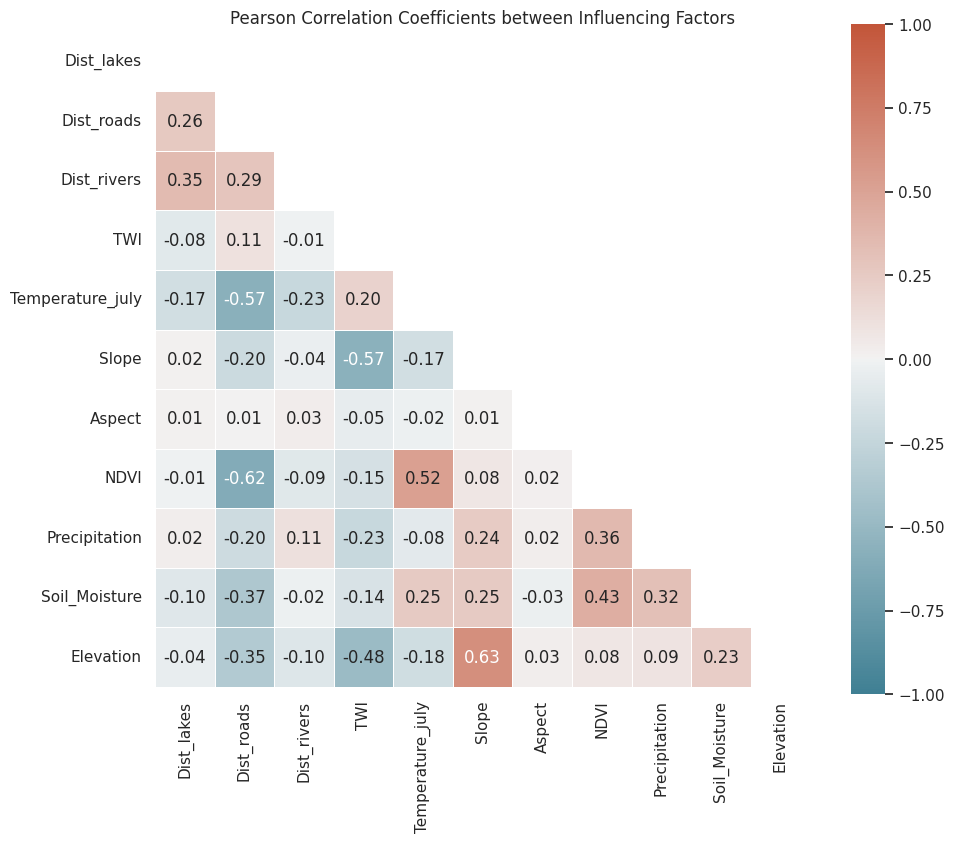

In [ ]:
# Dropping the categorical columns
numerical_df = df.drop(columns=['LULC', 'Wildfire_status'])

# Compute the correlation matrix
correlation_matrix = numerical_df.corr(method='pearson')

# Create a custom plot to visualize the correlation
plt.figure(figsize=(10, 10))
sns.set(style='white')

# Mask to show only the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Custom diverging palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            center=0, square=True, annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title('Pearson Correlation Coefficients between Influencing Factors')
plt.tight_layout()
plt.show()


### Split data into Training, Testing and Validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Separating features and target
X = df.drop(columns=['Wildfire_status'])
y = df['Wildfire_status']

# First split: 70% training, 30% temp (to be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: 50% validation, 50% testing from the 30% temp set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Data Preprocessing: Encode Categorical Features and Scale Numerical Features

from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

categorical_columns = ['LULC']
numerical_columns = ['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI',
                     'Temperature_july', 'Slope', 'Aspect', 'NDVI',
                     'Precipitation', 'Soil_Moisture', 'Elevation']

# Initialize the OneHotEncoder and StandardScaler
encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

# Fit and transform the encoder and scaler on the training data
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical_columns]), columns=numerical_columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[numerical_columns]), columns=numerical_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical_columns]), columns=numerical_columns)

# Concatenate the encoded and scaled features
X_train_final = pd.concat([X_train_scaled.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_scaled.reset_index(drop=True), X_val_encoded.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)


# First Approach of Feature Importrance and Feature Selection

1. Feature Importance using SHAP with XGBoost
2. Featuer Selection using LASSO

Train Accuracy: 99.56%
Validation Accuracy: 89.98%
Test Accuracy: 90.93%

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       989
           1       0.90      0.94      0.92      1216

    accuracy                           0.91      2205
   macro avg       0.91      0.91      0.91      2205
weighted avg       0.91      0.91      0.91      2205



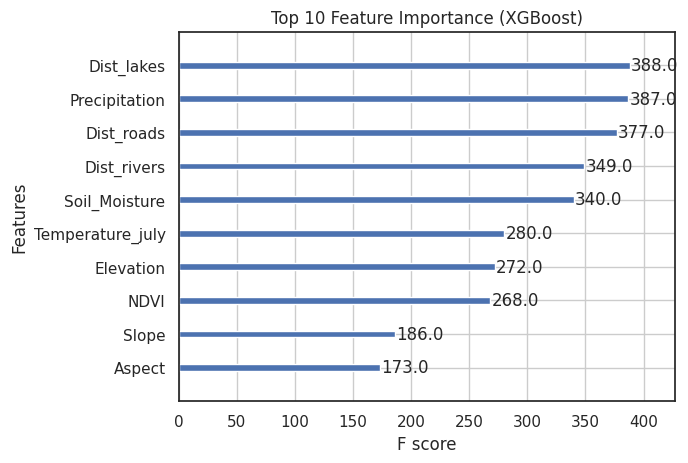

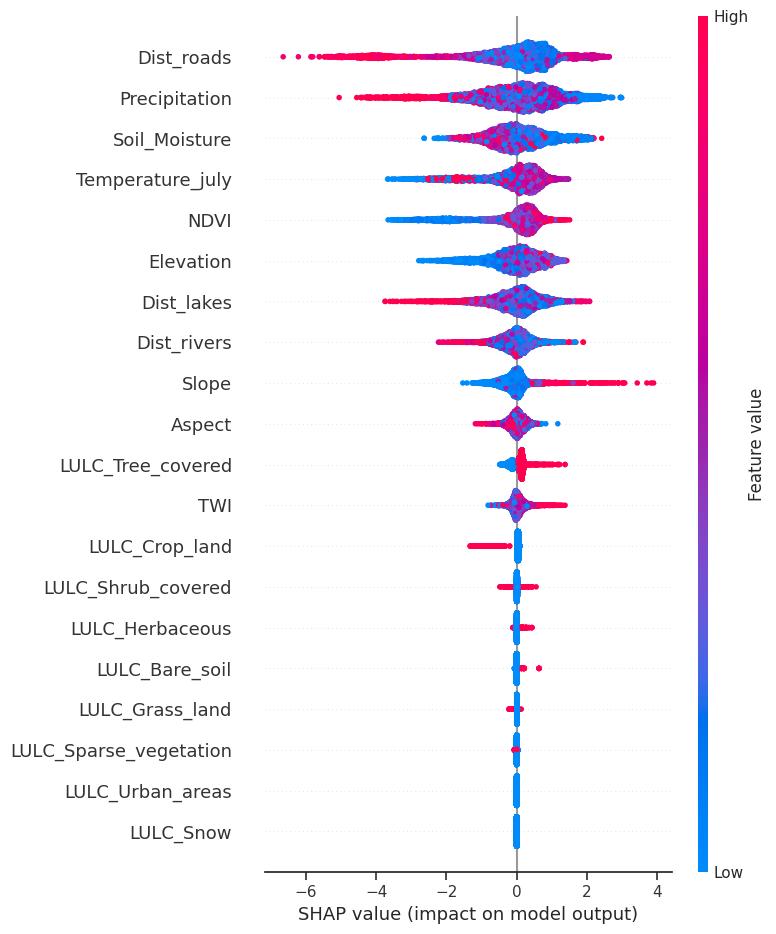

In [ ]:
# Feature Importance using XGBoost and SHAP

import xgboost as xgb
import shap
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initialize and train the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)

# Evaluate the model
y_pred_train = model.predict(X_train_final)
y_pred_val = model.predict(X_val_final)
y_pred_test = model.predict(X_test_final)

train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# Plot Feature Importance (XGBoost)
xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='Top 10 Feature Importance (XGBoost)')
plt.show()

# SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_final)

# Summary plot of SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_final)


 It's quite common in machine learning workflows to use one model for interpretation (like SHAP with XGBoost) and another for final training and predictions (like an ANN). The key is that the insights from SHAP inform you which features are important, and those features can then be used as inputs in any model, including ANN.

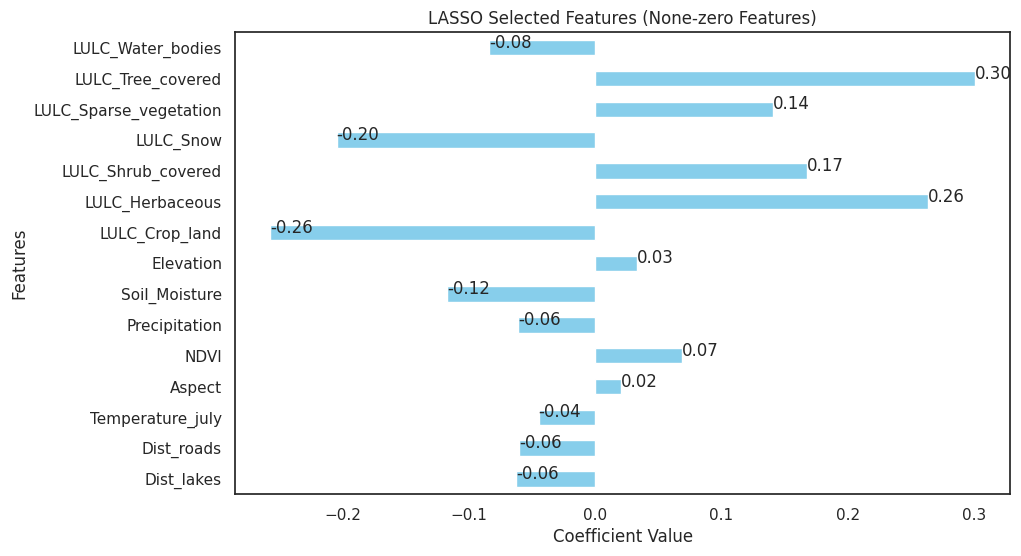

Selected features by LASSO with threshold:
Dist_lakes               -0.062359
Dist_roads               -0.060474
Temperature_july         -0.044774
Aspect                    0.020246
NDVI                      0.068495
Precipitation            -0.060815
Soil_Moisture            -0.117528
Elevation                 0.032774
LULC_Crop_land           -0.257248
LULC_Herbaceous           0.263407
LULC_Shrub_covered        0.167759
LULC_Snow                -0.204842
LULC_Sparse_vegetation    0.140865
LULC_Tree_covered         0.300874
LULC_Water_bodies        -0.083879
dtype: float64

Features removed by LASSO with threshold:
Dist_rivers        -0.001584
TWI                 0.011231
Slope               0.013077
LULC_Bare_soil      0.000000
LULC_Grass_land    -0.012077
LULC_Urban_areas   -0.015199
dtype: float64


In [ ]:
from sklearn.linear_model import LassoCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize and fit LASSO with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_final, y_train)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X_train_final.columns)

# Define a threshold for filtering coefficients close to zero
threshold = 0.02

# Filter coefficients based on the threshold
filtered_coefficients = lasso_coefficients[np.abs(lasso_coefficients) >= threshold]

# Identify removed features (those with coefficients below the threshold)
removed_features = lasso_coefficients[np.abs(lasso_coefficients) < threshold]

# Plot the filtered coefficients with values next to each bar
plt.figure(figsize=(10, 6))
ax = filtered_coefficients.plot(kind='barh', color='skyblue')

# Add values next to each bar
for index, value in enumerate(filtered_coefficients):
    plt.text(value, index, f'{value:.2f}')

plt.title(f'LASSO Selected Features (None-zero Features)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# Print the selected features
print("Selected features by LASSO with threshold:")
print(filtered_coefficients)

# Print the removed features
print("\nFeatures removed by LASSO with threshold:")
print(removed_features)


* Workflow: After running LASSO, you obtained a subset of features that are deemed important. These selected features are what you should use as inputs for your deep learning model (e.g., Artificial Neural Network, ANN). The removed features, which had coefficients close to zero, should be excluded from the training process as they are considered to add little to no value.
* Benefits: This approach helps reduce model complexity, can speed up training, and might lead to better generalization by reducing the risk of overfitting.

# Second Approach

1. Feature Importance using Boruta
2. Feature Selection using CART

* Boruta Algorithm: Boruta was applied for feature selection using random forest model to identify important features. This will resulted in a summary table indicating which features were confirmed, or rejected.

* CART (Classification and Regression Trees): Decision Tree model (CART) was applied to calculate the RI of each feature.

## Apply Boruta for Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pandas as pd
import numpy as np

# Assuming X_train_final and y_train are your preprocessed training data and labels

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Fit the RandomForest model to get the feature importances
rf.fit(X_train_final, y_train)

# Initialize Boruta with the random forest model
boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)

# Fit Boruta on the preprocessed training data
boruta.fit(X_train_final.values, y_train.values)

# Check lengths before creating DataFrame
print("Number of columns in X_train_final:", len(X_train_final.columns))
print("Length of mean_importances:", len(rf.feature_importances_))

# Ensure lengths match
if len(X_train_final.columns) != len(rf.feature_importances_):
    print("Warning: Mismatch in the number of features. Adjusting the arrays.")
    mean_importances = rf.feature_importances_[:len(X_train_final.columns)]
else:
    mean_importances = rf.feature_importances_

# Create a DataFrame for the summary
feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'MeanImp': mean_importances,
    'MedianImp': mean_importances,  # Using mean_importances for simplicity
    'MinImp': mean_importances,  # Using mean_importances for simplicity
    'MaxImp': mean_importances,  # Using mean_importances for simplicity
    'NormHits': boruta.support_.astype(int),
    'Decision': ['Confirmed' if decision else 'Rejected' for decision in boruta.support_]
})

# Sort the DataFrame by Mean Importance
feature_stats = feature_stats.sort_values(by='MeanImp', ascending=False)

# Display the summary table
print(feature_stats)


Number of columns in X_train_final: 21
Length of mean_importances: 32
                 Variables   MeanImp  MedianImp    MinImp    MaxImp  NormHits  \
7                     NDVI  0.192552   0.192552  0.192552  0.192552         1   
1               Dist_roads  0.177326   0.177326  0.177326  0.177326         1   
4         Temperature_july  0.117997   0.117997  0.117997  0.117997         1   
8            Precipitation  0.108419   0.108419  0.108419  0.108419         1   
15      LULC_Shrub_covered  0.090381   0.090381  0.090381  0.090381         0   
9            Soil_Moisture  0.083924   0.083924  0.083924  0.083924         1   
0               Dist_lakes  0.045560   0.045560  0.045560  0.045560         1   
12          LULC_Crop_land  0.044408   0.044408  0.044408  0.044408         1   
10               Elevation  0.041464   0.041464  0.041464  0.041464         1   
2              Dist_rivers  0.027854   0.027854  0.027854  0.027854         1   
11          LULC_Bare_soil  0.013856   

In [ ]:
# Save the summary table as a CSV file if needed
feature_stats.to_csv('boruta_feature_stats.csv', index=False)


### Feature Selection using CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Initialize the DecisionTreeClassifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the CART model to the training data
cart_model.fit(X_train_final, y_train)

# Extract feature importances
feature_importances = cart_model.feature_importances_

# Create a DataFrame for the summary
cart_feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'RelativeImportance': feature_importances
})

# Sort the DataFrame by Relative Importance
cart_feature_stats = cart_feature_stats.sort_values(by='RelativeImportance', ascending=False)

# Display the summary table
print(cart_feature_stats)


                 Variables  RelativeImportance
8            Precipitation            0.149608
7                     NDVI            0.148608
1               Dist_roads            0.138429
4         Temperature_july            0.134751
0               Dist_lakes            0.111864
9            Soil_Moisture            0.093023
2              Dist_rivers            0.066791
10               Elevation            0.046905
5                    Slope            0.043582
6                   Aspect            0.026640
3                      TWI            0.015802
18       LULC_Tree_covered            0.009023
12          LULC_Crop_land            0.006796
15      LULC_Shrub_covered            0.003573
11          LULC_Bare_soil            0.002400
17  LULC_Sparse_vegetation            0.001303
13         LULC_Grass_land            0.000901
14         LULC_Herbaceous            0.000000
16               LULC_Snow            0.000000
19        LULC_Urban_areas            0.000000
20       LULC

In [ ]:
# Save the summary table as a CSV file if needed
cart_feature_stats.to_csv('cart_feature_importance.csv', index=False)

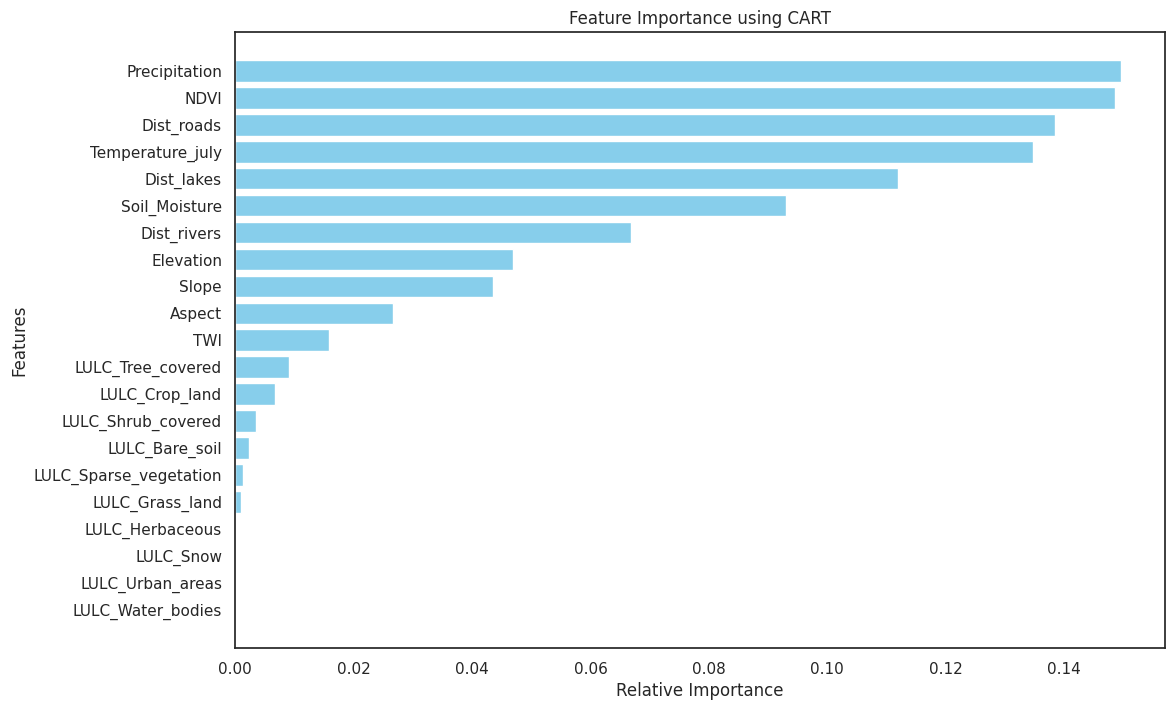

In [ ]:
# Plot the feature importances using a bar chart
plt.figure(figsize=(12, 8))
plt.barh(cart_feature_stats['Variables'], cart_feature_stats['RelativeImportance'], color='skyblue')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importance using CART')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


<ipython-input-18-e47500a07fd6>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Relative Importance', data=importance_long_df, palette="coolwarm")


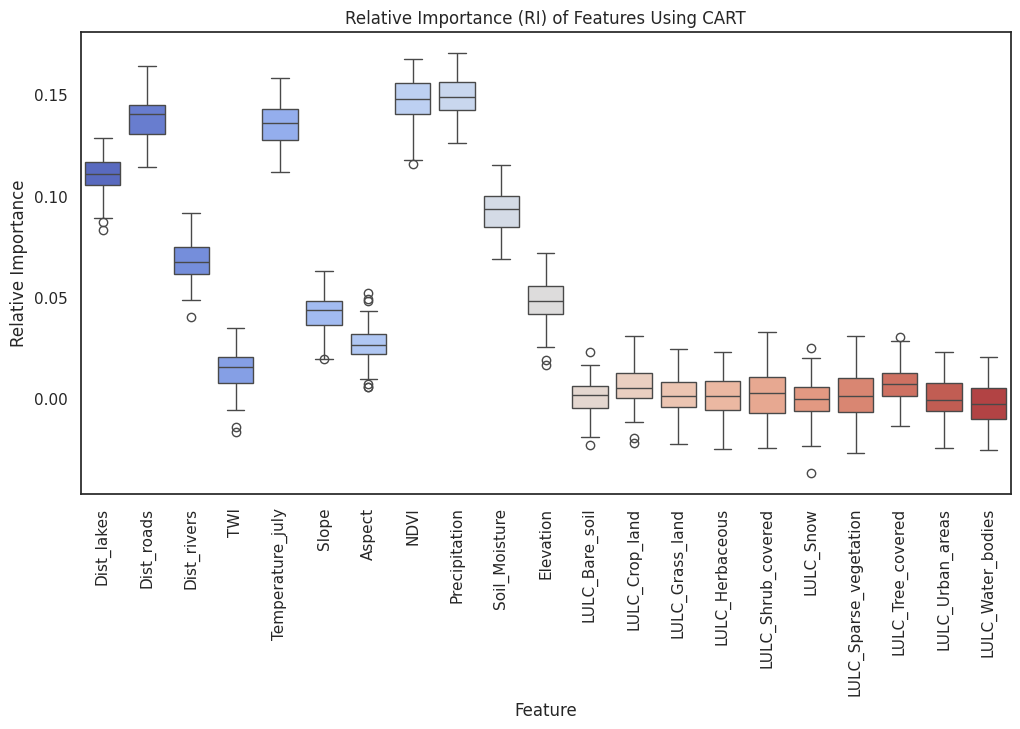

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Assuming X_train_final and y_train are your preprocessed training data and labels

# Initialize the DecisionTreeClassifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the CART model to the training data
cart_model.fit(X_train_final, y_train)

# Extract feature importances
feature_importances = cart_model.feature_importances_

# Simulate multiple samples of feature importance (for demonstration purposes)
num_simulations = 100
simulated_importances = []

for i in range(num_simulations):
    # Create slightly perturbed versions of the importances
    perturbed_importances = feature_importances + np.random.normal(0, 0.01, len(feature_importances))
    simulated_importances.append(perturbed_importances)

# Convert the simulated importances into a DataFrame for plotting
importance_df = pd.DataFrame(simulated_importances, columns=X_train_final.columns)

# Convert to long format for seaborn boxplot
importance_long_df = pd.melt(importance_df, var_name='Feature', value_name='Relative Importance')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Relative Importance', data=importance_long_df, palette="coolwarm")
plt.xticks(rotation=90)
plt.title('Relative Importance (RI) of Features Using CART')
plt.show()


<ipython-input-19-f268c017f708>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Feature', y='Relative Importance', data=importance_long_df, palette=palette)
<ipython-input-19-f268c017f708>:39: UserWarning: 
The palette list has fewer values (20) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Feature', y='Relative Importance', data=importance_long_df, palette=palette)


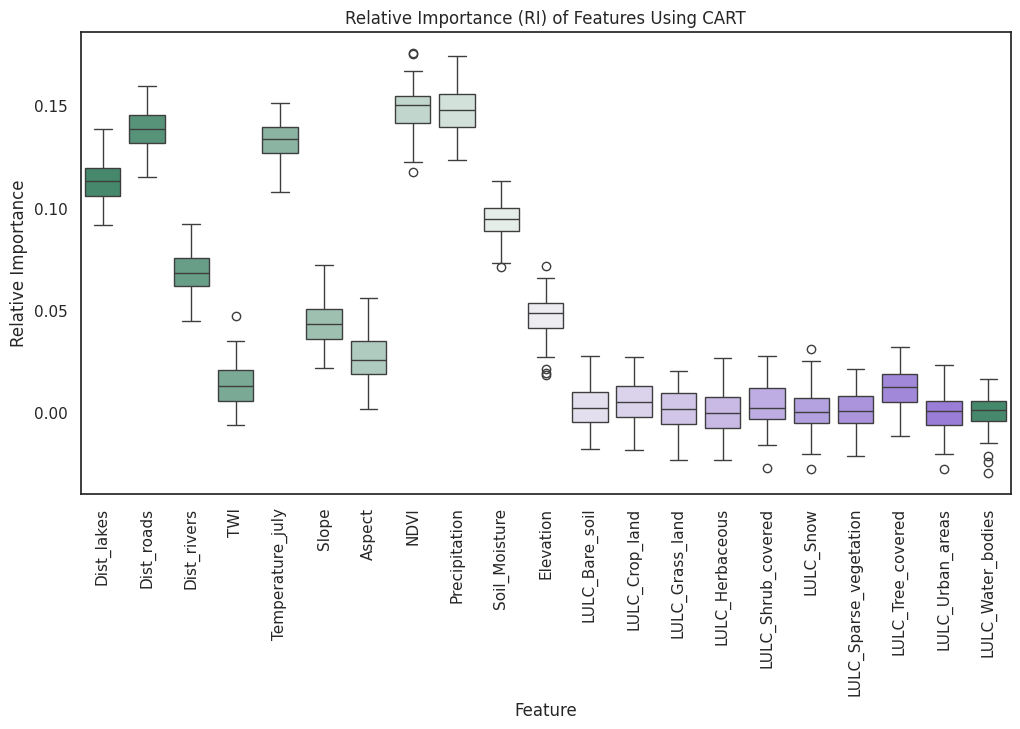

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Assuming X_train_final and y_train are your preprocessed training data and labels

# Initialize the DecisionTreeClassifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the CART model to the training data
cart_model.fit(X_train_final, y_train)

# Extract feature importances
feature_importances = cart_model.feature_importances_

# Simulate multiple samples of feature importance (for demonstration purposes)
num_simulations = 100
simulated_importances = []

for i in range(num_simulations):
    # Create slightly perturbed versions of the importances
    perturbed_importances = feature_importances + np.random.normal(0, 0.01, len(feature_importances))
    simulated_importances.append(perturbed_importances)

# Convert the simulated importances into a DataFrame for plotting
importance_df = pd.DataFrame(simulated_importances, columns=X_train_final.columns)

# Convert to long format for seaborn boxplot
importance_long_df = pd.melt(importance_df, var_name='Feature', value_name='Relative Importance')

# Use a palette that transitions from green to yellow to red
palette = sns.diverging_palette(150, 275, s=80, l=55, n=20)

# Create the boxplot with the new palette
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Relative Importance', data=importance_long_df, palette=palette)
plt.xticks(rotation=90)
plt.title('Relative Importance (RI) of Features Using CART')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import pandas as pd
import numpy as np

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Fit the RandomForest model to get the feature importances
rf.fit(X_train_final, y_train)

# Initialize Boruta with the random forest model
boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)

# Fit Boruta on the preprocessed training data
boruta.fit(X_train_final.values, y_train.values)

# Create a DataFrame for the Boruta results
boruta_feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'BorutaDecision': ['Confirmed' if decision else 'Rejected' for decision in boruta.support_]
})

# Initialize the DecisionTreeClassifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the CART model to the training data
cart_model.fit(X_train_final, y_train)

# Extract feature importances
feature_importances = cart_model.feature_importances_

# Create a DataFrame for the CART results
cart_feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'RelativeImportance': feature_importances
})

# Combine Boruta and CART results
combined_feature_stats = boruta_feature_stats.merge(cart_feature_stats, on='Variables')

# Features removed by Boruta
boruta_removed_features = combined_feature_stats[combined_feature_stats['BorutaDecision'] == 'Rejected']['Variables']

# Features with very low importance in CART (you can set a threshold, here we use 0.001 as an example)
cart_removed_features = combined_feature_stats[combined_feature_stats['RelativeImportance'] < 0.001]['Variables']

# Combine the removed features from both methods
removed_features = pd.concat([boruta_removed_features, cart_removed_features]).unique()

# Print removed features
print("Features removed by Boruta or CART:", removed_features)

# Display the final feature stats for those that are kept
final_feature_stats = combined_feature_stats[~combined_feature_stats['Variables'].isin(removed_features)]
print(final_feature_stats)


Features removed by Boruta or CART: ['LULC_Herbaceous' 'LULC_Shrub_covered' 'LULC_Snow'
 'LULC_Sparse_vegetation' 'LULC_Urban_areas' 'LULC_Water_bodies'
 'LULC_Grass_land']
            Variables BorutaDecision  RelativeImportance
0          Dist_lakes      Confirmed            0.111864
1          Dist_roads      Confirmed            0.138429
2         Dist_rivers      Confirmed            0.066791
3                 TWI      Confirmed            0.015802
4    Temperature_july      Confirmed            0.134751
5               Slope      Confirmed            0.043582
6              Aspect      Confirmed            0.026640
7                NDVI      Confirmed            0.148608
8       Precipitation      Confirmed            0.149608
9       Soil_Moisture      Confirmed            0.093023
10          Elevation      Confirmed            0.046905
11     LULC_Bare_soil      Confirmed            0.002400
12     LULC_Crop_land      Confirmed            0.006796
18  LULC_Tree_covered      Co

## Feature Importance Using Boruta and Feature Selection with CART then store the removed features in the variable and then drop these features from Dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from boruta import BorutaPy
import pandas as pd
import numpy as np

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# Fit the RandomForest model to get the feature importances
rf.fit(X_train_final, y_train)

# Initialize Boruta with the random forest model
boruta = BorutaPy(estimator=rf, n_estimators='auto', max_iter=100, random_state=42)

# Fit Boruta on the preprocessed training data
boruta.fit(X_train_final.values, y_train.values)

# Create a DataFrame for the Boruta results
boruta_feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'BorutaDecision': ['Confirmed' if decision else 'Rejected' for decision in boruta.support_]
})

# Initialize the DecisionTreeClassifier (CART)
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the CART model to the training data
cart_model.fit(X_train_final, y_train)

# Extract feature importances
feature_importances = cart_model.feature_importances_

# Create a DataFrame for the CART results
cart_feature_stats = pd.DataFrame({
    'Variables': X_train_final.columns,
    'RelativeImportance': feature_importances
})

# Combine Boruta and CART results
combined_feature_stats = boruta_feature_stats.merge(cart_feature_stats, on='Variables')

# Features removed by Boruta
boruta_removed_features = combined_feature_stats[combined_feature_stats['BorutaDecision'] == 'Rejected']['Variables']

# Features with very low importance in CART (threshold < 0.001)
cart_removed_features = combined_feature_stats[combined_feature_stats['RelativeImportance'] < 0.001]['Variables']

# Combine the removed features from both methods
removed_features = pd.concat([boruta_removed_features, cart_removed_features]).unique()

# Print removed features
print("Features removed by Boruta or CART:", removed_features)

# Display the final feature stats for those that are kept
final_feature_stats = combined_feature_stats[~combined_feature_stats['Variables'].isin(removed_features)]
print(final_feature_stats)

# Drop the removed features from the datasets automatically
X_train_selected = X_train_final.drop(columns=removed_features)
X_val_selected = X_val_final.drop(columns=removed_features)
X_test_selected = X_test_final.drop(columns=removed_features)


Features removed by Boruta or CART: ['LULC_Herbaceous' 'LULC_Shrub_covered' 'LULC_Snow'
 'LULC_Sparse_vegetation' 'LULC_Urban_areas' 'LULC_Water_bodies'
 'LULC_Grass_land']
            Variables BorutaDecision  RelativeImportance
0          Dist_lakes      Confirmed            0.111864
1          Dist_roads      Confirmed            0.138429
2         Dist_rivers      Confirmed            0.066791
3                 TWI      Confirmed            0.015802
4    Temperature_july      Confirmed            0.134751
5               Slope      Confirmed            0.043582
6              Aspect      Confirmed            0.026640
7                NDVI      Confirmed            0.148608
8       Precipitation      Confirmed            0.149608
9       Soil_Moisture      Confirmed            0.093023
10          Elevation      Confirmed            0.046905
11     LULC_Bare_soil      Confirmed            0.002400
12     LULC_Crop_land      Confirmed            0.006796
18  LULC_Tree_covered      Co

In [ ]:
# Print shapes of the final selected datasets
print("X_train_selected shape:", X_train_selected.shape)
print("X_val_selected shape:", X_val_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)


X_train_selected shape: (7717, 14)
X_val_selected shape: (1654, 14)
X_test_selected shape: (1654, 14)


In [ ]:
X_train_selected.head()

,Dist_lakes,Dist_roads,Dist_rivers,TWI,Temperature_july,Slope,Aspect,NDVI,Precipitation,Soil_Moisture,Elevation,LULC_Bare_soil,LULC_Crop_land,LULC_Tree_covered
0,-0.338762,-0.109231,-0.089714,0.934298,0.780860,-0.504419,-0.988136,-0.310215,-0.263428,0.102531,-0.801537,0.0,0.0,0.0
1,0.910740,3.504224,2.754084,-0.368484,-0.914113,-0.379883,0.955738,-1.862594,-0.475789,-0.896517,-0.515137,0.0,0.0,0.0
2,-0.252341,-0.824331,1.988888,-1.652332,-1.183768,1.704241,-0.725863,0.440795,1.307230,-0.447259,0.339040,0.0,0.0,1.0
3,0.632141,0.640096,1.982339,0.103765,-0.528892,-0.465246,1.093008,-0.156009,0.459280,-0.320820,-0.809074,0.0,0.0,1.0
4,-0.345064,-0.737032,0.338627,0.435488,0.934949,-0.489436,-0.643115,1.598601,0.608942,1.656504,-0.341789,0.0,0.0,1.0


In [ ]:
X_train_selected.columns

Index(['Dist_lakes', 'Dist_roads', 'Dist_rivers', 'TWI', 'Temperature_july',
       'Slope', 'Aspect', 'NDVI', 'Precipitation', 'Soil_Moisture',
       'Elevation', 'LULC_Bare_soil', 'LULC_Crop_land', 'LULC_Tree_covered'],
      dtype='object')

# Deep Learning models

## ANN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4917 - loss: 0.7489 - val_accuracy: 0.5719 - val_loss: 0.6917
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5355 - loss: 0.6973 - val_accuracy: 0.5544 - val_loss: 0.6887
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5486 - loss: 0.6915 - val_accuracy: 0.5514 - val_loss: 0.6869
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5553 - loss: 0.6890 - val_accuracy: 0.5719 - val_loss: 0.6834
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5591 - loss: 0.6848 - val_accuracy: 0.5883 - val_loss: 0.6780
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5539 - loss: 0.6840 - val_accuracy: 0.6143 - val_loss: 0.6726
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5589 - loss: 0.6811 - val_accuracy: 0.6638 - val_loss: 0.6607
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5620 - loss: 0.6768 - val_accuracy: 0

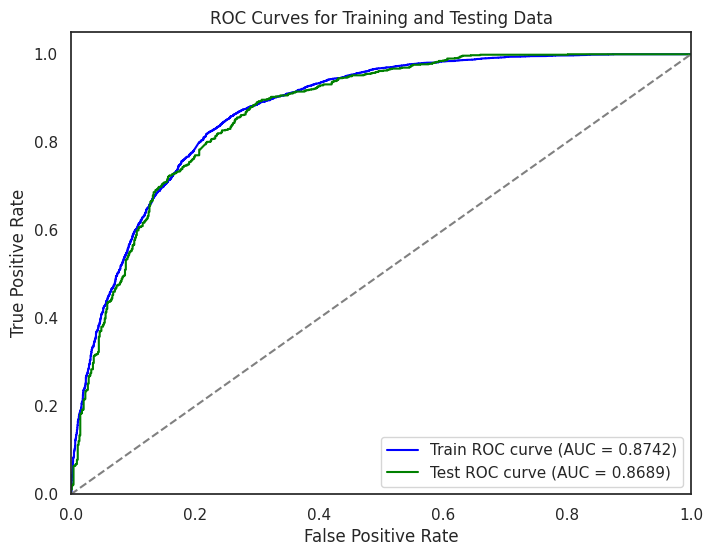

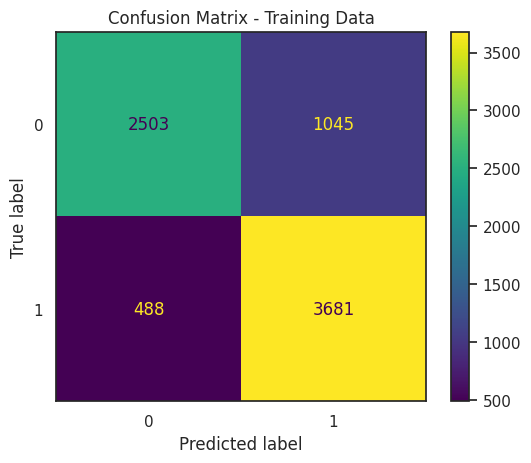

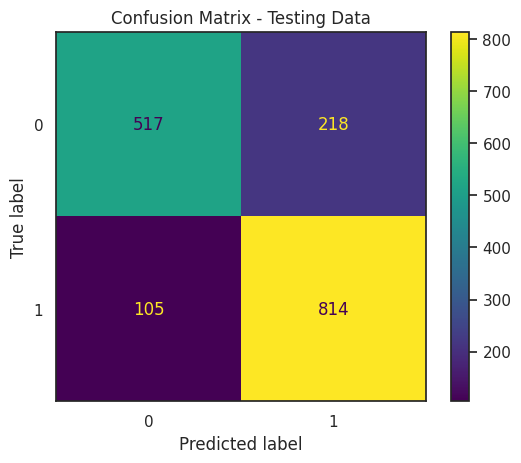

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Building the ANN model
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(units=32, activation='relu', input_dim=X_train_selected.shape[1]))
model.add(Dropout(0.5))

# Adding the second hidden layer
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))

# Adding the third hidden layer
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.5))

# Adding the fourth hidden layer
model.add(Dense(units=4, activation='relu'))
model.add(Dropout(0.5))

# Adding the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the ANN
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Fitting the ANN to the training set
history = model.fit(X_train_selected, y_train, validation_data=(X_val_selected, y_val), epochs=30, batch_size=32)

# Predicting probabilities
y_train_proba = model.predict(X_train_selected).ravel()
y_test_proba = model.predict(X_test_selected).ravel()

# Calculating ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Plotting ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {train_auc:.4f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc="lower right")
plt.show()

# Predicting class labels
y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()


## RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 14, 32)              │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 14, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 14, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 14, 8)               │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,129 (8.32 KB)

 Trainable params: 2,129 (8.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5253 - loss: 0.7696 - val_accuracy: 0.5502 - val_loss: 0.6898
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.5495 - loss: 0.6904 - val_accuracy: 0.5502 - val_loss: 0.6884
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5664 - loss: 0.6849 - val_accuracy: 0.5502 - val_loss: 0.6841
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5720 - loss: 0.6793 - val_accuracy: 0.5520 - val_loss: 0.6829
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5623 - loss: 0.6796 - val_accuracy: 0.5659 - val_loss: 0.6749
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5869 - loss: 0.6668 - val_accuracy: 0.5967 - val_loss: 0.6659
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5744 - loss: 0.6758 - val_accuracy: 0.6070 - val_loss: 0.6604
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5933 - loss: 0.6628 - val

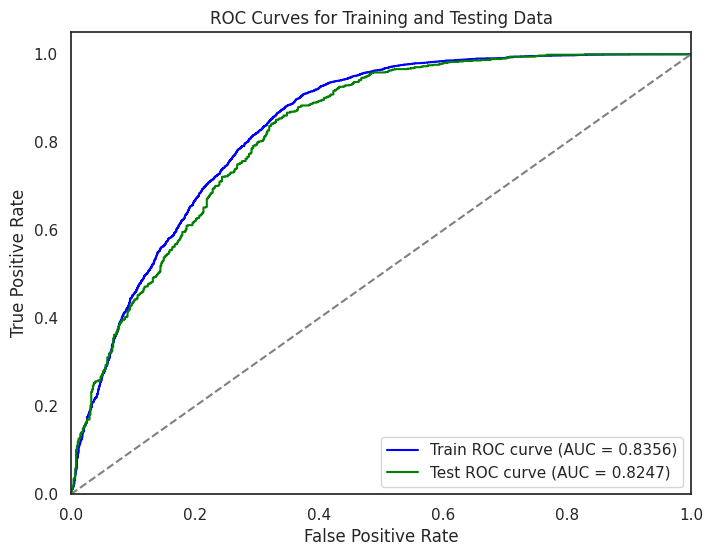

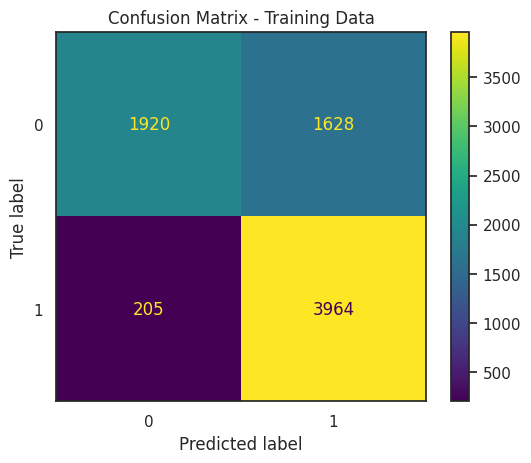

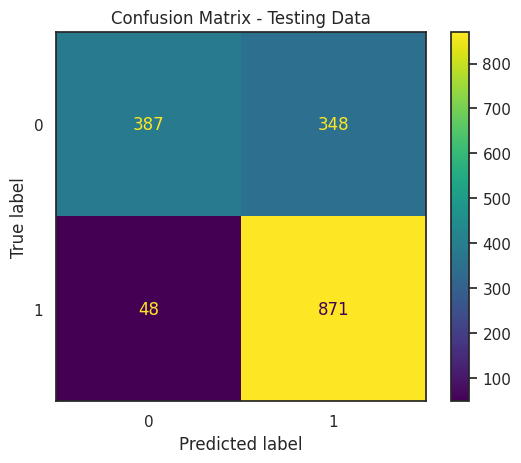

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Building the RNN model
model = Sequential()

# Adding the RNN layers
model.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train_selected.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(units=16, activation='relu', return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(units=8, activation='relu', return_sequences=True))
model.add(Dropout(0.5))

model.add(SimpleRNN(units=4, activation='relu'))
model.add(Dropout(0.5))

# Adding the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the RNN
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Reshape the input data to fit the RNN input shape
X_train_reshaped = np.expand_dims(X_train_selected, axis=-1)
X_val_reshaped = np.expand_dims(X_val_selected, axis=-1)
X_test_reshaped = np.expand_dims(X_test_selected, axis=-1)

# Fitting the RNN to the training set
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=30, batch_size=32)

# Predicting probabilities
y_train_proba = model.predict(X_train_reshaped).ravel()
y_test_proba = model.predict(X_test_reshaped).ravel()

# Calculating ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Plotting ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {train_auc:.4f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc="lower right")
plt.show()

# Predicting class labels
y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()


## Encoder-Decoder BiRNN

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 14, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ [(None, 256), (None,   │        133,120 │ input_layer_2[0][0]    │
│ (Bidirectional)           │ 128), (None, 128),     │                │                        │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ bidirectional[0][1],   │
│                           │                        │                │ bidirectional[0][3]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 1, 256)         │              0 │ concatenate[0][0]      │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256)            │              0 │ bidirectional[0][2],   │
│ (Concatenate)             │                        │                │ bidirectional[0][4]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ repeat_vector[0][0],   │
│                           │                        │                │ concatenate[0][0],     │
│                           │                        │                │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │            257 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 658,689 (2.51 MB)

 Trainable params: 658,689 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.5832 - loss: 0.6673 - val_accuracy: 0.6481 - val_loss: 0.6314
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.6129 - loss: 0.6431 - val_accuracy: 0.6185 - val_loss: 0.6281
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.6331 - loss: 0.6248 - val_accuracy: 0.6100 - val_loss: 0.6409
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6444 - loss: 0.6124 - val_accuracy: 0.6475 - val_loss: 0.6309
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.6360 - loss: 0.6108 - val_accuracy: 0.6620 - val_loss: 0.6102
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.6542 - loss: 0.5990 - val_accuracy: 0.6288 - val_loss: 0.6414
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6653 - loss: 0.5834 - val_accuracy: 0.6584 - val_loss: 0.6283
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6733 - loss: 0.5753 - 

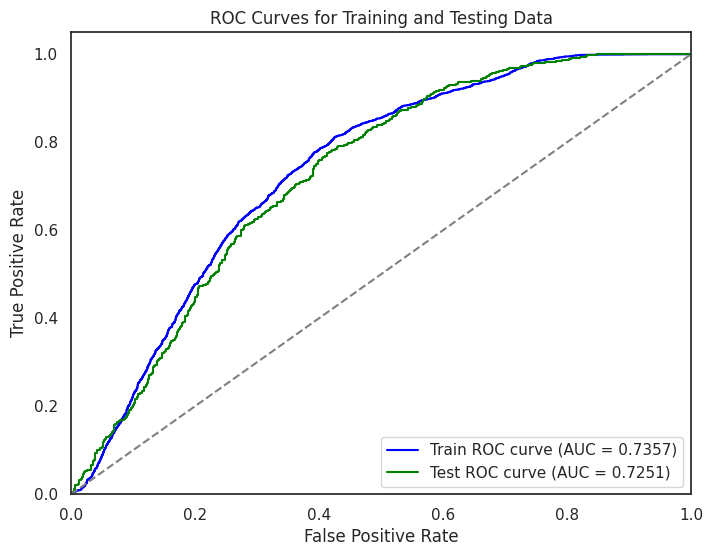

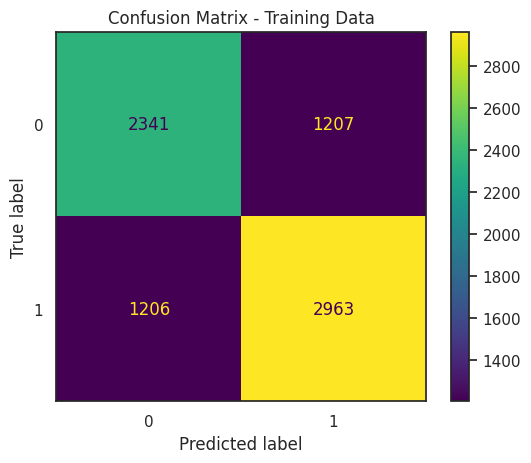

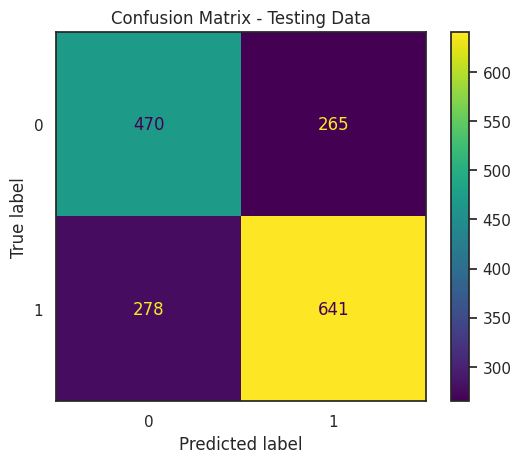

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the number of units for the RNN
units = 128

# Encoder
encoder_inputs = Input(shape=(X_train_selected.shape[1], 1))
encoder = Bidirectional(LSTM(units, return_state=True, dropout=0.5))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = tf.keras.layers.RepeatVector(1)(state_h)  # we are repeating the context vector as input
decoder_lstm = LSTM(units * 2, return_sequences=False, dropout=0.5)  # *2 because of bidirectionality
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1, activation='sigmoid')
outputs = decoder_dense(decoder_outputs)

# Build the model
model = Model(inputs=encoder_inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Reshape the input data to fit the RNN input shape
X_train_reshaped = np.expand_dims(X_train_selected, axis=-1)
X_val_reshaped = np.expand_dims(X_val_selected, axis=-1)
X_test_reshaped = np.expand_dims(X_test_selected, axis=-1)

# Fitting the model to the training set
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=30, batch_size=32)

# Predicting probabilities
y_train_proba = model.predict(X_train_reshaped).ravel()
y_test_proba = model.predict(X_test_reshaped).ravel()

# Calculating ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Plotting ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {train_auc:.4f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc="lower right")
plt.show()

# Predicting class labels
y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()


## Elman RNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,745 (10.72 KB)

 Trainable params: 2,745 (10.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5282 - loss: 0.6913 - val_accuracy: 0.5520 - val_loss: 0.6832
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5346 - loss: 0.6861 - val_accuracy: 0.6469 - val_loss: 0.6611
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5714 - loss: 0.6740 - val_accuracy: 0.7497 - val_loss: 0.5892
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6082 - loss: 0.6419 - val_accuracy: 0.7672 - val_loss: 0.5729
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6214 - loss: 0.6288 - val_accuracy: 0.7509 - val_loss: 0.5626
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6189 - loss: 0.6237 - val_accuracy: 0.7594 - val_loss: 0.5318
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6406 - loss: 0.6043 - val_accuracy: 0.7696 - val_loss: 0.5389
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6587 - loss: 0.5905 - val_accuracy: 0.

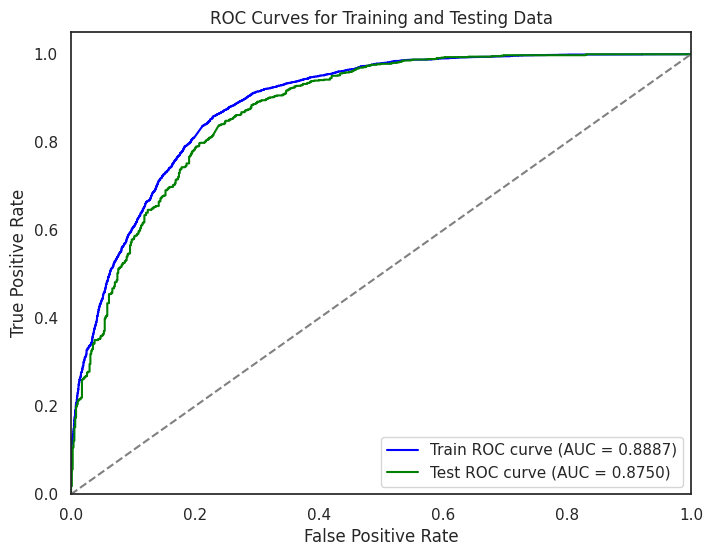

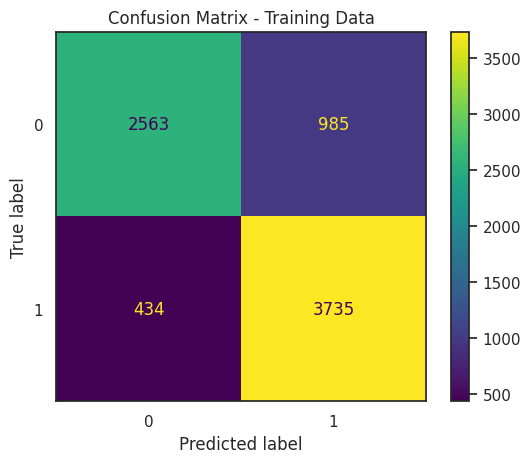

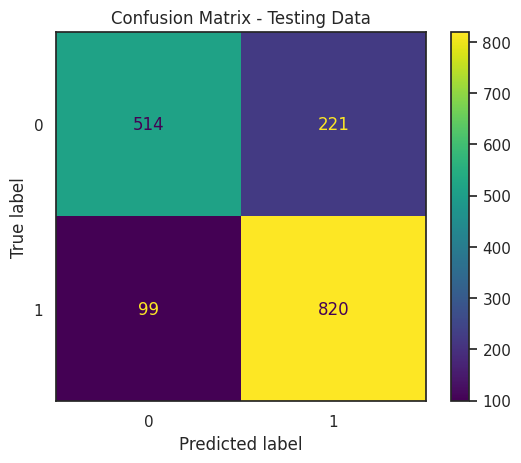

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Building the Elman RNN model
model = Sequential()

# Adding the SimpleRNN layer (Elman RNN)
model.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train_selected.shape[1], 1), return_sequences=False))
model.add(Dropout(0.5))

# Adding a Dense layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

# Adding a Dense layer
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.5))

# Adding a Dense layer
model.add(Dense(units=4, activation='relu'))
model.add(Dropout(0.5))

# Adding the output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Reshape the input data to fit the RNN input shape
X_train_reshaped = np.expand_dims(X_train_selected, axis=-1)
X_val_reshaped = np.expand_dims(X_val_selected, axis=-1)
X_test_reshaped = np.expand_dims(X_test_selected, axis=-1)

# Fitting the model to the training set
history = model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=30, batch_size=32)

# Predicting probabilities
y_train_proba = model.predict(X_train_reshaped).ravel()
y_test_proba = model.predict(X_test_reshaped).ravel()

# Calculating ROC AUC scores
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# Plotting ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC curve (AUC = {train_auc:.4f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Training and Testing Data')
plt.legend(loc="lower right")
plt.show()

# Predicting class labels
y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Confusion Matrix - Testing Data")
plt.show()


# ALL ML models in one Block of code with different hidden layers(32, 16, 8, 4, 1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
                       Accuracy  Precision  Sensitivity  Specificity  F1 Score
ANN                    0.790810   0.735802     0.972797     0.563265  0.837863
RNN                    0.765417   0.853529     0.697497     0.850340  0.767665
ElmanRNN               0.804111   0.786885     0.887922     0.699320  0.834356
Encoder_Decoder_BiRNN  0.732769   0.713901     0.866159     0.565986  0.782694


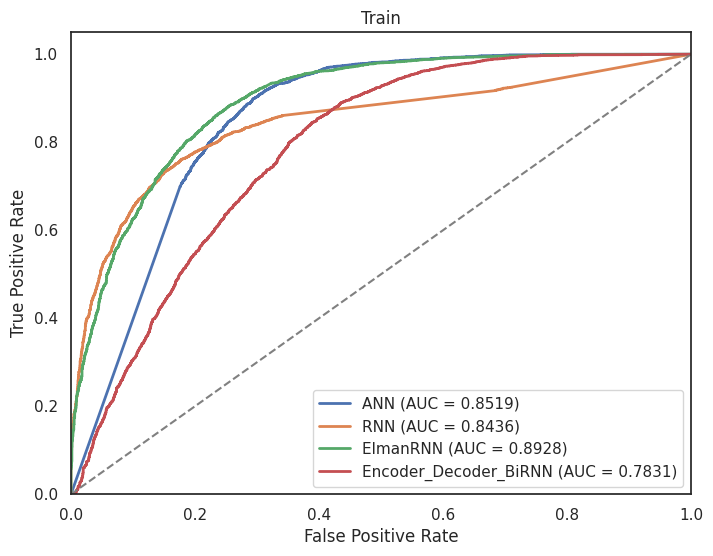

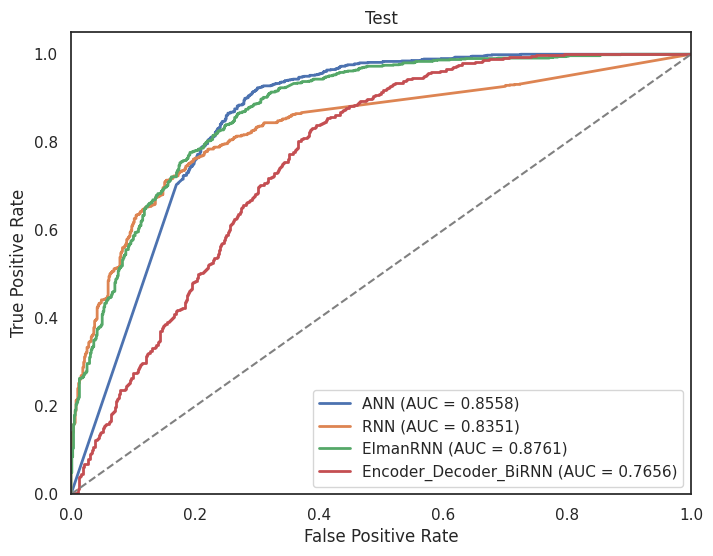

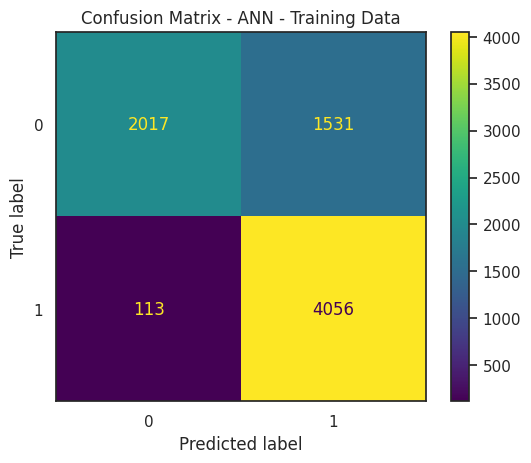

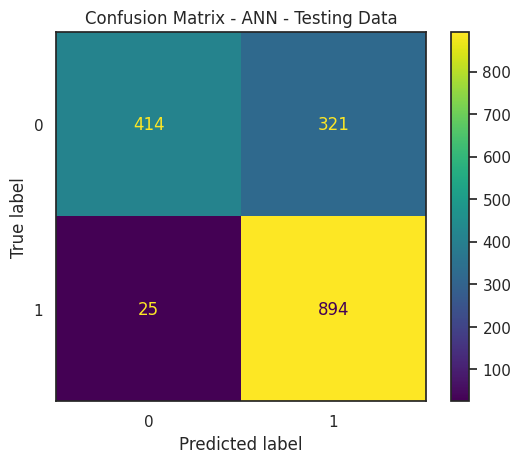

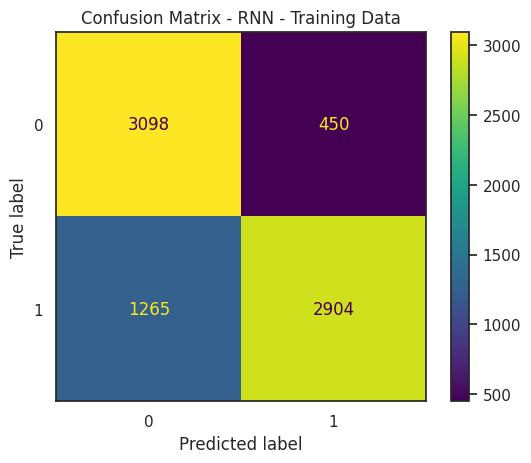

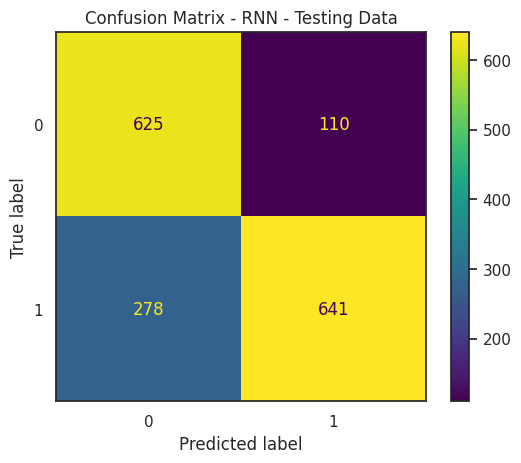

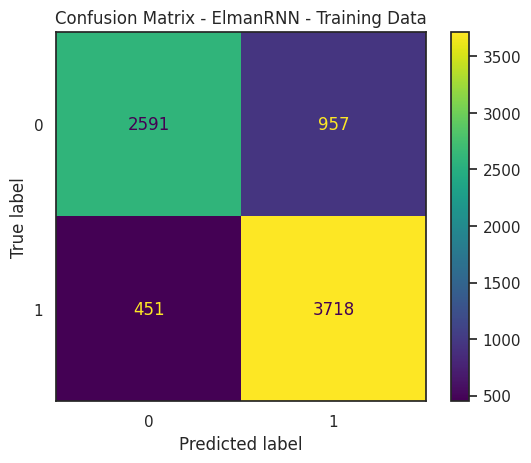

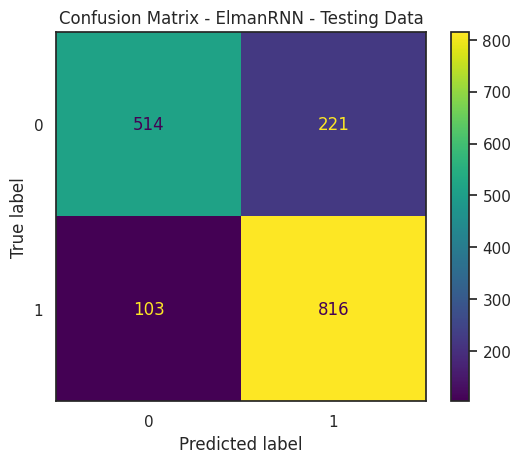

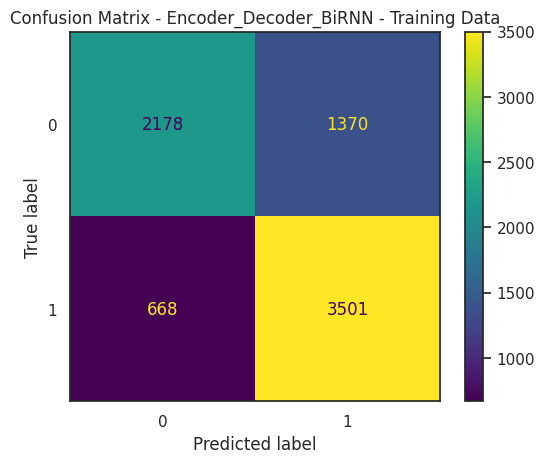

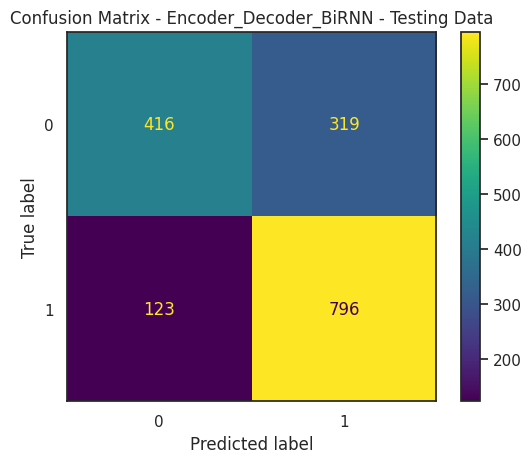

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Function to build and train each model
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, X_test, y_test):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=32, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=4, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=16, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=8, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=4, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=8, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=4, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        units = 128
        encoder_inputs = Input(shape=(X_train.shape[1], 1))
        encoder = Bidirectional(LSTM(units, return_state=True, dropout=0.5))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        decoder_inputs = tf.keras.layers.RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units * 2, return_sequences=False, dropout=0.5)
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Reshape input data for RNN models
    if model_type != 'ANN':
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    # Predict probabilities
    y_train_proba = model.predict(X_train).ravel()
    y_test_proba = model.predict(X_test).ravel()

    # Calculate ROC AUC scores
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # Predict class labels
    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])
    f1 = f1_score(y_test, y_test_pred)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

    # ROC curve data
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    return fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics

# Prepare lists to store the results for all models
fprs_train, tprs_train, aucs_train = [], [], []
fprs_test, tprs_test, aucs_test = [], [], []
cms_train, cms_test = [], []
metrics_data = {}

# Define model types
models = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']

# Train models and gather ROC data and metrics
for model_type in models:
    fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics = build_and_train_model(
        model_type, X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)

    fprs_train.append((fpr_train, tpr_train, train_auc))
    fprs_test.append((fpr_test, tpr_test, test_auc))
    cms_train.append(cm_train)
    cms_test.append(cm_test)
    metrics_data[model_type] = metrics

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Save the DataFrame to a CSV file
metrics_df.to_csv('model_metrics.csv', index=True)

# Display the DataFrame
print(metrics_df)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_train):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_test):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test')
plt.legend(loc="lower right")
plt.show()

# Optionally, display confusion matrices for each model
for i, model_type in enumerate(models):
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cms_train[i])
    disp_train.plot()
    plt.title(f"Confusion Matrix - {model_type} - Training Data")
    plt.show()

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cms_test[i])
    disp_test.plot()
    plt.title(f"Confusion Matrix - {model_type} - Testing Data")
    plt.show()


### add hidden layers (64, 32, 16, 16, 1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
                       Accuracy  Precision  Sensitivity  Specificity  F1 Score
ANN                    0.825272   0.780749     0.953210     0.665306  0.858403
RNN                    0.841596   0.805014     0.943417     0.714286  0.868737
ElmanRNN               0.843410   0.803867     0.949946     0.710204  0.870823
Encoder_Decoder_BiRNN  0.682588   0.716960     0.708379     0.650340  0.712644


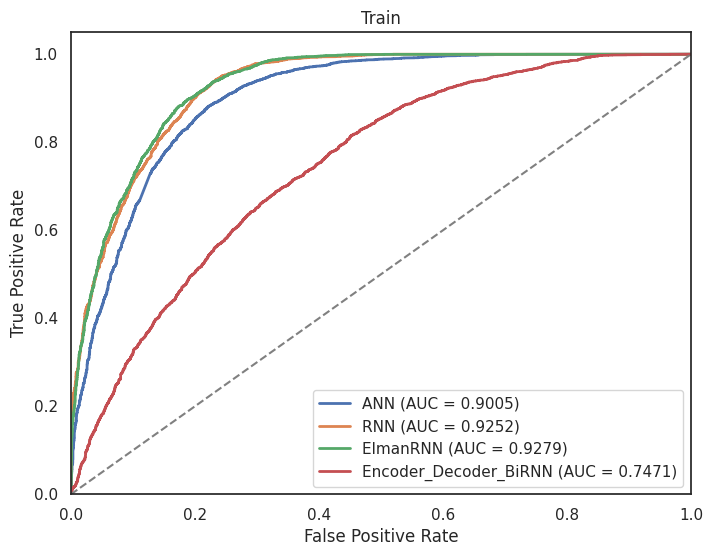

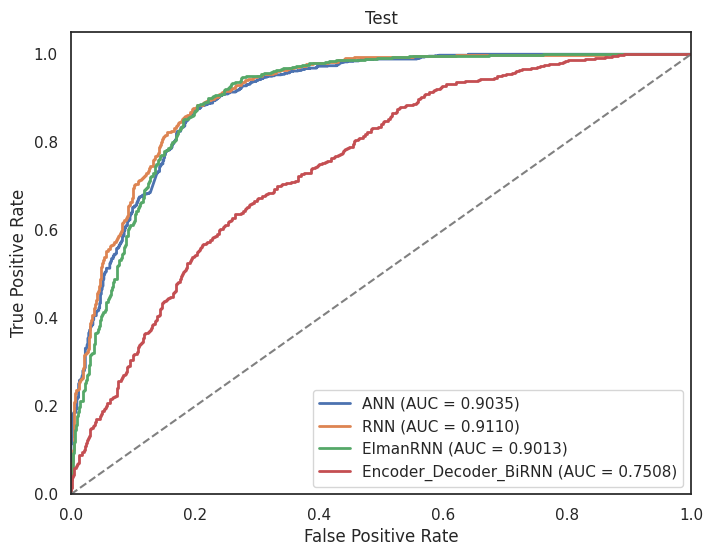

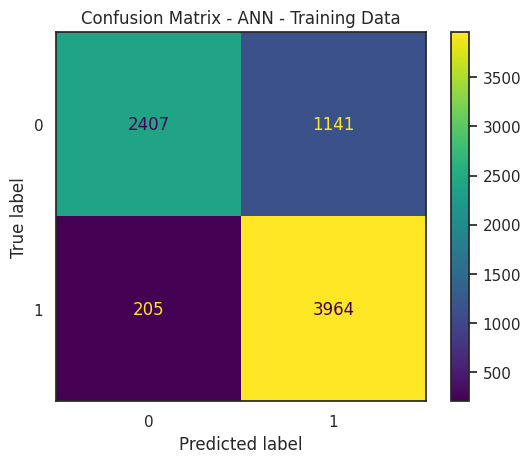

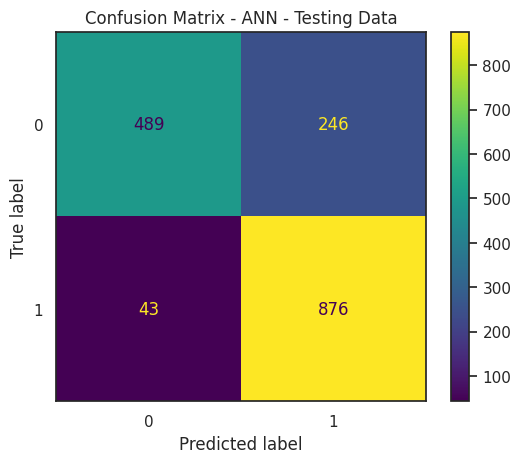

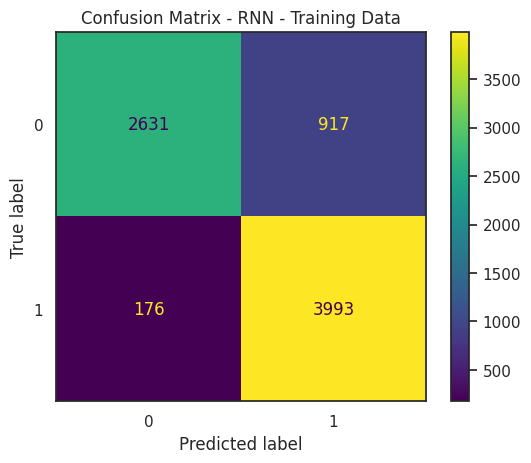

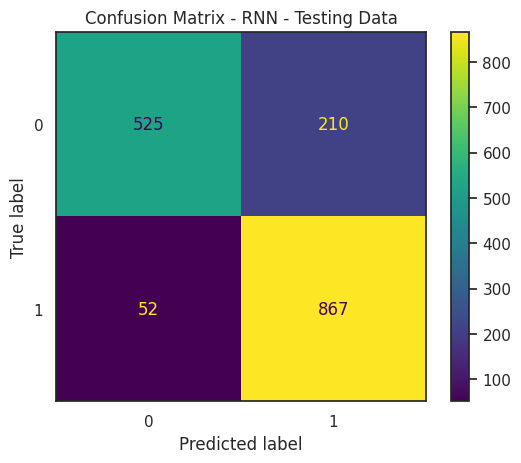

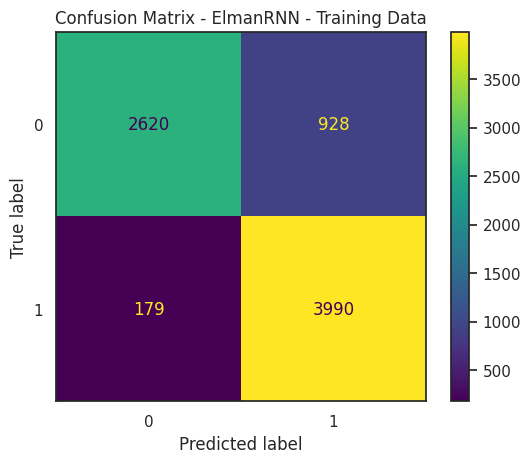

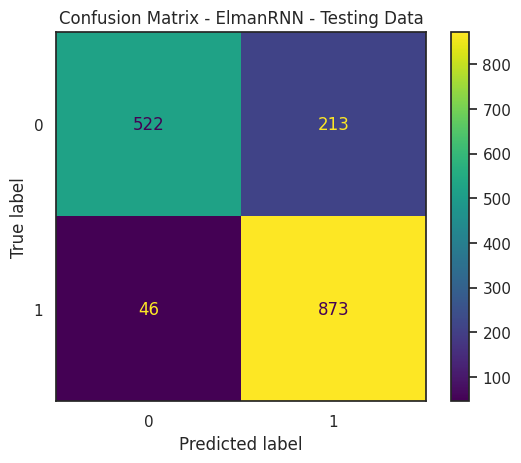

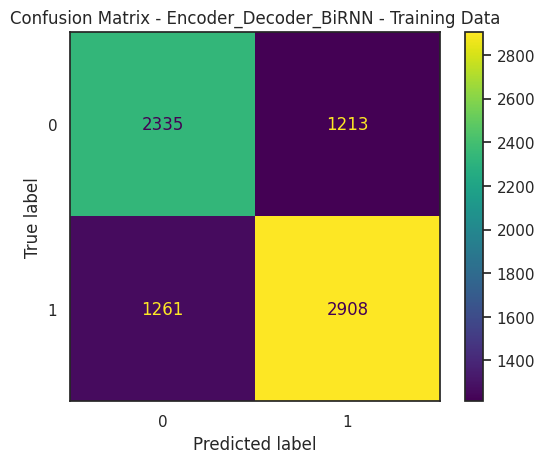

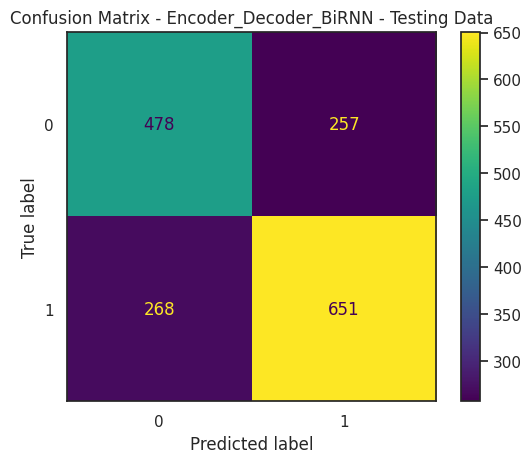

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Function to build and train each model
def build_and_train_model(model_type, X_train, y_train, X_val, y_val, X_test, y_test):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(0.5))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=32, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=16, activation='relu', return_sequences=True))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=False))
        model.add(Dropout(0.5))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        units = 128
        encoder_inputs = Input(shape=(X_train.shape[1], 1))
        encoder = Bidirectional(LSTM(units, return_state=True, dropout=0.5))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        decoder_inputs = tf.keras.layers.RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units * 2, return_sequences=False, dropout=0.5)
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Reshape input data for RNN models
    if model_type != 'ANN':
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=0)

    # Predict probabilities
    y_train_proba = model.predict(X_train).ravel()
    y_test_proba = model.predict(X_test).ravel()

    # Calculate ROC AUC scores
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # Predict class labels
    y_train_pred = (y_train_proba > 0.5).astype(int)
    y_test_pred = (y_test_proba > 0.5).astype(int)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])
    f1 = f1_score(y_test, y_test_pred)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

    # ROC curve data
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    return fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics

# Prepare lists to store the results for all models
fprs_train, tprs_train, aucs_train = [], [], []
fprs_test, tprs_test, aucs_test = [], [], []
cms_train, cms_test = [], []
metrics_data = {}

# Define model types
models = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']

# Train models and gather ROC data and metrics
for model_type in models:
    fpr_train, tpr_train, train_auc, fpr_test, tpr_test, test_auc, cm_train, cm_test, metrics = build_and_train_model(
        model_type, X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test)

    fprs_train.append((fpr_train, tpr_train, train_auc))
    fprs_test.append((fpr_test, tpr_test, test_auc))
    cms_train.append(cm_train)
    cms_test.append(cm_test)
    metrics_data[model_type] = metrics

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Save the DataFrame to a CSV file
metrics_df.to_csv('model_metrics2.csv', index=True)

# Display the DataFrame
print(metrics_df)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_train):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for i, (fpr, tpr, auc) in enumerate(fprs_test):
    plt.plot(fpr, tpr, lw=2, label=f'{models[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test')
plt.legend(loc="lower right")
plt.show()

# Optionally, display confusion matrices for each model
for i, model_type in enumerate(models):
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cms_train[i])
    disp_train.plot()
    plt.title(f"Confusion Matrix - {model_type} - Training Data")
    plt.show()

    disp_test = ConfusionMatrixDisplay(confusion_matrix=cms_test[i])
    disp_test.plot()
    plt.title(f"Confusion Matrix - {model_type} - Testing Data")
    plt.show()


# Optimising ANN with Black Widow Optimization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1/3, Best Fitness: 0.31018558144569397


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 2/3, Best Fitness: 0.31018558144569397


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 3/3, Best Fitness: 0.31018558144569397
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6056 - loss: 0.6446 - val_accuracy: 0.7604 - val_loss: 0.4981
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7397 - loss: 0.5292 - val_accuracy: 0.7822 - val_loss: 0.4613
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7676 - loss: 0.4949 - val_accuracy: 0.7976 - val_loss: 0.4340
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7858 - loss: 0.4691 - val_accuracy: 0.8122 - val_loss: 0.4215
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7981 - loss: 0.4446 - val_accuracy: 0.8258 - val_loss: 0.4022
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8068 - loss: 0.4350 - val_accuracy: 0.8267 - val_loss: 0.3937
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8062 - loss: 0.4332 - val_accuracy: 0.8294 - val_loss: 0.3839
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8089 - loss: 0.4144 - val_accuracy: 0.8403 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.35825860500335693


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.3581946790218353


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 3/3, Best Fitness: 0.33213675022125244
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6277 - loss: 0.6420 - val_accuracy: 0.7586 - val_loss: 0.4933
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7689 - loss: 0.4977 - val_accuracy: 0.8031 - val_loss: 0.4352
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7915 - loss: 0.4535 - val_accuracy: 0.8122 - val_loss: 0.4259
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8007 - loss: 0.4367 - val_accuracy: 0.8103 - val_loss: 0.4076
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8259 - loss: 0.3953 - val_accuracy: 0.8140 - val_loss: 0.3858
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8215 - loss: 0.3956 - val_accuracy: 0.8276 - val_loss: 0.3827
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8391 - loss: 0.3723 - val_accuracy: 0.8230 - val_loss: 0.3914
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8336 - loss: 0.3846 - val_accuracy: 0.835

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.33603668212890625


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.32936355471611023


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 3/3, Best Fitness: 0.32936355471611023
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6576 - loss: 0.6308 - val_accuracy: 0.7505 - val_loss: 0.5027
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7609 - loss: 0.5091 - val_accuracy: 0.7813 - val_loss: 0.4591
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7893 - loss: 0.4669 - val_accuracy: 0.7931 - val_loss: 0.4398
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8139 - loss: 0.4317 - val_accuracy: 0.8131 - val_loss: 0.4022
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8209 - loss: 0.4107 - val_accuracy: 0.8312 - val_loss: 0.3792
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8227 - loss: 0.4042 - val_accuracy: 0.8412 - val_loss: 0.3659
Epoch 7/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8300 - loss: 0.3912 - val_accuracy: 0.8385 - val_loss: 0.3780
Epoch 8/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8382 - loss: 0.3741 - val_accuracy: 0.8376 - val

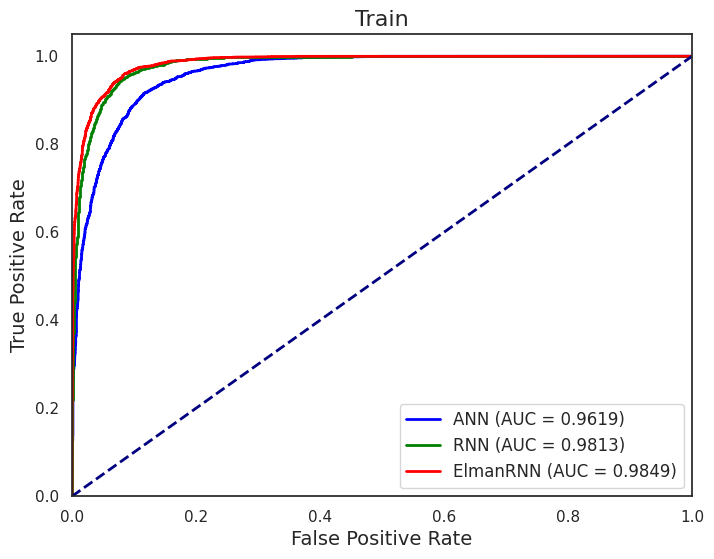

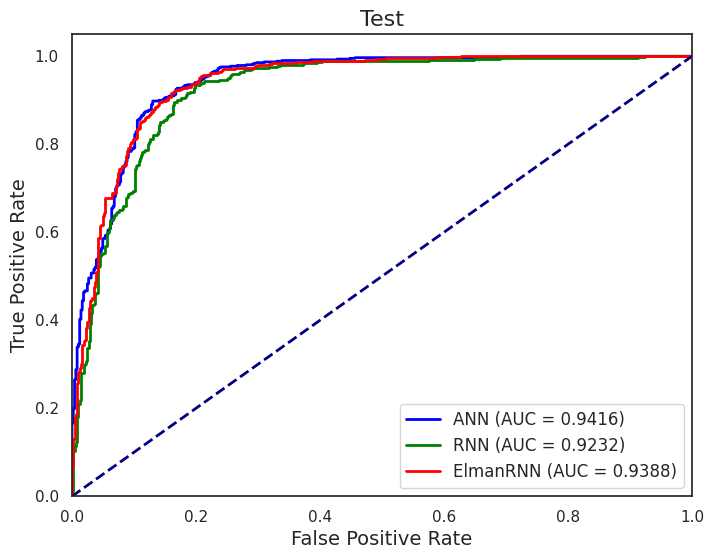

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    model = Sequential()
    if model_type == 'ANN':
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    return model

# Function to initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units1': int((spider['units1'] + partner['units1']) / 2),
                'units2': int((spider['units2'] + partner['units2']) / 2),
                'units3': int((spider['units3'] + partner['units3']) / 2),
                'dropout1': (spider['dropout1'] + partner['dropout1']) / 2,
                'dropout2': (spider['dropout2'] + partner['dropout2']) / 2,
                'dropout3': (spider['dropout3'] + partner['dropout3']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize model using BWO
def bwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'dropout': (0.1, 0.5)
    }
    population = initialize_bwo_population(3, param_bounds)
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            model = create_model(model_type, spider, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=30, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 3)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types
model_types = ['ANN', 'RNN', 'ElmanRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = bwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('optimized_ann_rnn_elman_metrics.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
# plt.savefig('/content/roc_train2.jpg', dpi=600, format='jpg')
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
# plt.savefig('/content/roc_test2.jpg', dpi=600, format='jpg')
plt.show()


Add Encoder-decoder BiRNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1/3, Best Fitness: 0.30172672867774963


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 2/3, Best Fitness: 0.30172672867774963


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 3/3, Best Fitness: 0.30172672867774963
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6181 - loss: 0.6426 - val_accuracy: 0.7769 - val_loss: 0.4888
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7483 - loss: 0.5245 - val_accuracy: 0.7872 - val_loss: 0.4561
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7678 - loss: 0.4985 - val_accuracy: 0.8077 - val_loss: 0.4280
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7911 - loss: 0.4611 - val_accuracy: 0.8156 - val_loss: 0.4095
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7950 - loss: 0.4498 - val_accuracy: 0.8210 - val_loss: 0.3952
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8094 - loss: 0.4284 - val_accuracy: 0.8198 - val_loss: 0.3958
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8003 - loss: 0.4335 - val_accuracy: 0.8295 - val_loss: 0.3757
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8147 - loss: 0.4122 - val_accuracy: 0.8313 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.348324179649353


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.348324179649353


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 3/3, Best Fitness: 0.348324179649353
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6555 - loss: 0.6155 - val_accuracy: 0.7775 - val_loss: 0.4636
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7666 - loss: 0.4902 - val_accuracy: 0.8096 - val_loss: 0.4184
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7937 - loss: 0.4456 - val_accuracy: 0.8271 - val_loss: 0.3951
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8088 - loss: 0.4231 - val_accuracy: 0.8368 - val_loss: 0.3718
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8261 - loss: 0.3989 - val_accuracy: 0.8434 - val_loss: 0.3604
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8389 - loss: 0.3856 - val_accuracy: 0.8319 - val_loss: 0.3940
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8405 - loss: 0.3677 - val_accuracy: 0.8362 - val_loss: 0.3710
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8417 - loss: 0.3544 - val_accuracy: 0.833

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.3435865342617035


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.3435865342617035


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 3/3, Best Fitness: 0.3435865342617035
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6333 - loss: 0.6349 - val_accuracy: 0.7866 - val_loss: 0.4730
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7643 - loss: 0.5079 - val_accuracy: 0.8071 - val_loss: 0.4361
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7972 - loss: 0.4621 - val_accuracy: 0.8083 - val_loss: 0.4336
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7975 - loss: 0.4525 - val_accuracy: 0.8337 - val_loss: 0.3945
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8040 - loss: 0.4475 - val_accuracy: 0.8265 - val_loss: 0.3900
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8252 - loss: 0.4086 - val_accuracy: 0.8392 - val_loss: 0.3789
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8266 - loss: 0.4006 - val_accuracy: 0.8343 - val_loss: 0.3744
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8297 - loss: 0.3948 - val_accuracy: 0.8319 - val_

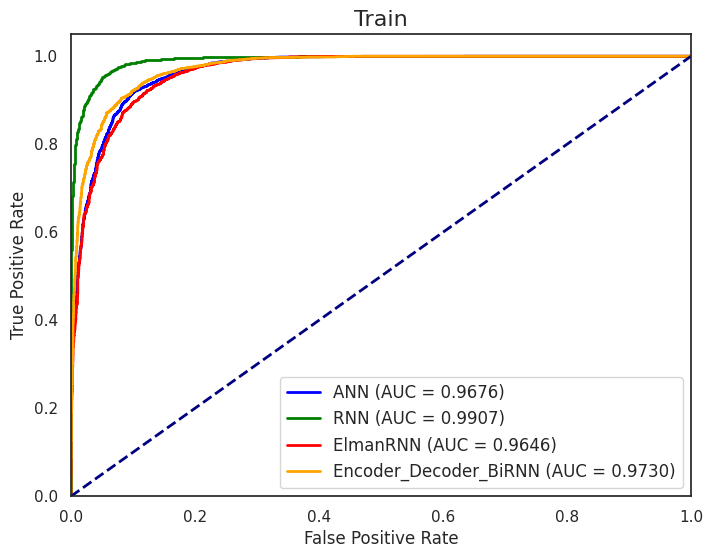

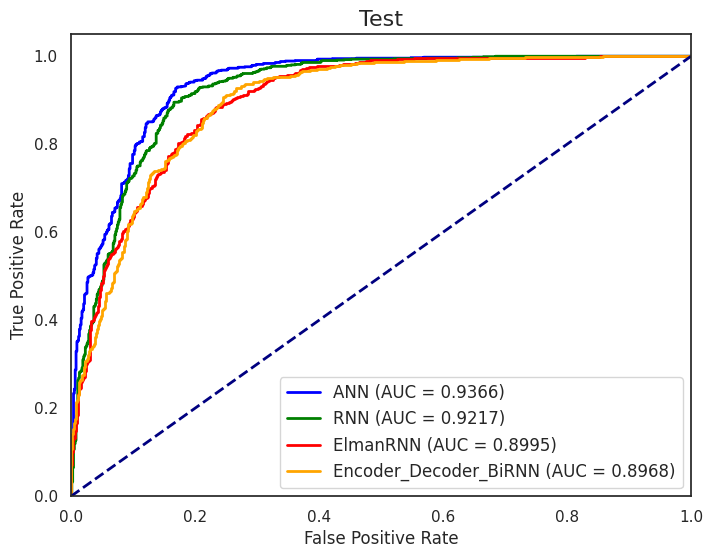

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, Bidirectional, LSTM, RepeatVector, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Function to initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units1': int((spider['units1'] + partner['units1']) / 2),
                'units2': int((spider['units2'] + partner['units2']) / 2),
                'units3': int((spider['units3'] + partner['units3']) / 2),
                'dropout1': (spider['dropout1'] + partner['dropout1']) / 2,
                'dropout2': (spider['dropout2'] + partner['dropout2']) / 2,
                'dropout3': (spider['dropout3'] + partner['dropout3']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize model using BWO
def bwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'dropout': (0.1, 0.5)
    }
    population = initialize_bwo_population(3, param_bounds)
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            model = create_model(model_type, spider, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=30, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 3)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types including the new Encoder-Decoder BiRNN
model_types = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red', 'Encoder_Decoder_BiRNN': 'orange'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = bwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('optimized_ann_rnn_elman_metrics.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, Bidirectional, LSTM, RepeatVector, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout3']))
        model.add(SimpleRNN(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Function to initialize BWO population
def initialize_bwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        spider = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'units4': np.random.randint(param_bounds['units4'][0], param_bounds['units4'][1] + 1),
            'units5': np.random.randint(param_bounds['units5'][0], param_bounds['units5'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout4': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout5': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'units1': int((spider['units1'] + partner['units1']) / 2),
                'units2': int((spider['units2'] + partner['units2']) / 2),
                'units3': int((spider['units3'] + partner['units3']) / 2),
                'units4': int((spider['units4'] + partner['units4']) / 2),
                'units5': int((spider['units5'] + partner['units5']) / 2),
                'dropout1': (spider['dropout1'] + partner['dropout1']) / 2,
                'dropout2': (spider['dropout2'] + partner['dropout2']) / 2,
                'dropout3': (spider['dropout3'] + partner['dropout3']) / 2,
                'dropout4': (spider['dropout4'] + partner['dropout4']) / 2,
                'dropout5': (spider['dropout5'] + partner['dropout5']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize model using BWO
def bwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'units4': (8, 16),
        'units5': (8, 8),
        'dropout': (0.1, 0.5)
    }
    population = initialize_bwo_population(3, param_bounds)
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            model = create_model(model_type, spider, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=30, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            spider['fitness'] = loss  # Lower loss is better

            if spider['fitness'] < best_fitness:
                best_fitness = spider['fitness']
                best_params = spider

        population = bwo_crossover_and_cannibalism(population)
        population = bwo_select_survivors(population, 3)
        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types including the new Encoder-Decoder BiRNN
model_types = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red', 'Encoder_Decoder_BiRNN': 'orange'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = bwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('optimized_ann_rnn_elman_metrics1.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 1/3, Best Fitness: 0.31665754318237305


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 2/3, Best Fitness: 0.3022598326206207


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generation 3/3, Best Fitness: 0.3022598326206207
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5881 - loss: 0.6672 - val_accuracy: 0.7684 - val_loss: 0.5066
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7280 - loss: 0.5500 - val_accuracy: 0.7920 - val_loss: 0.4565
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7685 - loss: 0.4963 - val_accuracy: 0.8114 - val_loss: 0.4341
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7778 - loss: 0.4782 - val_accuracy: 0.8283 - val_loss: 0.3980
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7974 - loss: 0.4529 - val_accuracy: 0.8380 - val_loss: 0.3877
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8026 - loss: 0.4372 - val_accuracy: 0.8343 - val_loss: 0.3842
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8073 - loss: 0.4341 - val_accuracy: 0.8289 - val_loss: 0.3849
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8117 - loss: 0.4149 - val_accuracy: 0.8398 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.35267212986946106


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.3506213128566742


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 3/3, Best Fitness: 0.3506213128566742


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5648 - loss: 0.6781 - val_accuracy: 0.7539 - val_loss: 0.5090
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7208 - loss: 0.5716 - val_accuracy: 0.7872 - val_loss: 0.4760
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7697 - loss: 0.5061 - val_accuracy: 0.8035 - val_loss: 0.4351
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7889 - loss: 0.4786 - val_accuracy: 0.8083 - val_loss: 0.4280
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.7912 - loss: 0.4619 - val_accuracy: 0.8150 - val_loss: 0.4132
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8069 - loss: 0.4375 - val_accuracy: 0.8283 - val_loss: 0.3849
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8162 - loss: 0.4167 - val_accuracy: 0.8247 - val_loss: 0.3920
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8202 - loss: 0.4108 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 1/3, Best Fitness: 0.36267703771591187


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Generation 2/3, Best Fitness: 0.3448103368282318


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Bidirectional, LSTM, Input, Concatenate, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)  # Repeating the context vector as input
        decoder_lstm = LSTM(params['units1'] * 2, return_sequences=False, dropout=params['dropout1'])  # *2 because of bidirectionality
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        # Build the model
        model = Model(inputs=encoder_inputs, outputs=outputs)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Compile the model if not Encoder_Decoder_BiRNN (since it's already compiled below)
    if model_type != 'Encoder_Decoder_BiRNN':
        model.compile(optimizer=Adam(learning_rate=params.get('learning_rate', 0.001)),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    return model

# Function to initialize BWO population
def initialize_bwo_population(pop_size, param_bounds, model_types):
    population = []
    for _ in range(pop_size):
        spider = {
            'model_type': np.random.choice(model_types),
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'learning_rate': np.random.uniform(0.0001, 0.01),  # Adding learning rate as a hyperparameter
            'fitness': None  # Initialize fitness
        }
        population.append(spider)
    return population

# BWO Crossover and Cannibalism
def bwo_crossover_and_cannibalism(population):
    new_population = []
    for spider in population:
        if np.random.rand() < 0.5:  # Random chance to mate
            partner = np.random.choice(population)
            child = {
                'model_type': spider['model_type'],  # Assuming same model type for crossover
                'units1': int((spider['units1'] + partner['units1']) / 2),
                'units2': int((spider['units2'] + partner['units2']) / 2),
                'units3': int((spider['units3'] + partner['units3']) / 2),
                'dropout1': (spider['dropout1'] + partner['dropout1']) / 2,
                'dropout2': (spider['dropout2'] + partner['dropout2']) / 2,
                'dropout3': (spider['dropout3'] + partner['dropout3']) / 2,
                'learning_rate': (spider['learning_rate'] + partner['learning_rate']) / 2,
                'fitness': None  # Reset fitness for new child
            }
            new_population.append(child)
        else:
            new_population.append(spider)
    return new_population

# Select survivors based on fitness
def bwo_select_survivors(population, max_population_size):
    # Ensure all spiders have a fitness value
    for spider in population:
        if spider['fitness'] is None:
            spider['fitness'] = float('inf')  # Assign worst fitness if not evaluated
    # Sort by fitness and select the top survivors
    sorted_population = sorted(population, key=lambda x: x['fitness'])
    return sorted_population[:max_population_size]

# Optimize model using BWO
def bwo_optimize(X_train, y_train, X_val, y_val, input_feature_count, model_types, param_bounds, pop_size=3, max_generations=3):
    population = initialize_bwo_population(pop_size, param_bounds, model_types)

    best_fitness = float('inf')
    best_params = None

    for generation in range(max_generations):
        for spider in population:
            if spider['fitness'] is None:
                # Create and compile the model
                model = create_model(spider['model_type'], spider, input_feature_count)

                # Compile the model if it's Encoder_Decoder_BiRNN
                if spider['model_type'] == 'Encoder_Decoder_BiRNN':
                    model.compile(optimizer=Adam(learning_rate=spider['learning_rate']),
                                  loss='binary_crossentropy',
                                  metrics=['accuracy'])

                # Reshape input data for RNN models
                if spider['model_type'] != 'ANN':
                    X_train_reshaped = np.expand_dims(X_train, axis=-1)
                    X_val_reshaped = np.expand_dims(X_val, axis=-1)
                else:
                    X_train_reshaped = X_train
                    X_val_reshaped = X_val

                # Train the model
                history = model.fit(X_train_reshaped, y_train,
                                    epochs=30,
                                    batch_size=32,
                                    validation_data=(X_val_reshaped, y_val),
                                    verbose=0)

                # Evaluate the model
                loss, accuracy = model.evaluate(X_val_reshaped, y_val, verbose=0)
                spider['fitness'] = loss  # Lower loss is better

                # Update best parameters
                if spider['fitness'] < best_fitness:
                    best_fitness = spider['fitness']
                    best_params = spider.copy()

        # Crossover and Cannibalism
        population = bwo_crossover_and_cannibalism(population)
        # Select survivors
        population = bwo_select_survivors(population, pop_size)

        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness:.4f}")

    return best_params

# Example model optimization and evaluation
# Assuming X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test are already defined
# Replace the following with your actual data
# For demonstration, creating dummy data
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train_val, X_test_selected, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_selected, X_val_selected, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

input_feature_count = X_train_selected.shape[1]

# Define model types
model_types = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red', 'Encoder_Decoder_BiRNN': 'purple'}

# Define parameter bounds
param_bounds = {
    'units1': (8, 128),
    'units2': (8, 64),
    'units3': (8, 32),
    'dropout': (0.1, 0.5)
}

# Initialize dictionaries to store results
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Initialize list to store confusion matrices
cms_train = {}
cms_test = {}

# Optimize and evaluate each model
for model_type in model_types:
    print(f"Optimizing model: {model_type}")
    best_params = bwo_optimize(X_train_selected, y_train, X_val_selected, y_val,
                               input_feature_count, model_types, param_bounds,
                               pop_size=3, max_generations=3)
    print(f"Best parameters for {model_type}: {best_params}\n")

    # Create and compile the best model
    model = create_model(model_type, best_params, input_feature_count)

    # Compile the model if it's Encoder_Decoder_BiRNN
    if model_type == 'Encoder_Decoder_BiRNN':
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Reshape input data for RNN models
    if model_type != 'ANN':
        X_train_reshaped = np.expand_dims(X_train_selected, axis=-1)
        X_val_reshaped = np.expand_dims(X_val_selected, axis=-1)
        X_test_reshaped = np.expand_dims(X_test_selected, axis=-1)
    else:
        X_train_reshaped = X_train_selected
        X_val_reshaped = X_val_selected
        X_test_reshaped = X_test_selected

    # Train the model
    history = model.fit(X_train_reshaped, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_data=(X_val_reshaped, y_val),
                        verbose=0)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f"Test Loss for {model_type}: {test_loss:.4f}")
    print(f"Test Accuracy for {model_type}: {test_accuracy:.4f}")

    # Predict probabilities
    y_train_probs = model.predict(X_train_reshaped).ravel()
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    cms_test[model_type] = cm

    # For training confusion matrix
    y_train_pred = (y_train_probs >= 0.5).astype(int)
    cm_train = confusion_matrix(y_train, y_train_pred)
    cms_train[model_type] = cm_train

    tn, fp, fn, tp = cm.ravel() if cm.shape == (2,2) else (0,0,0,0)  # Handle cases where not binary

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, zero_division=0)
    recall = recall_score(y_test, y_test_pred, zero_division=0)  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, y_test_pred, zero_division=0)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print("\nPerformance Metrics for All Models:")
print(metrics_df)

# Save the DataFrame to a CSV file
metrics_df.to_csv('optimized_models_metrics.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(10, 8))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict.get(model_type, 'black'), lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Training Data', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(10, 8))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict.get(model_type, 'black'), lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Testing Data', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# Display confusion matrices for each model
for model_type in model_types:
    # Training Confusion Matrix
    if model_type in cms_train and cms_train[model_type].shape == (2,2):
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cms_train[model_type])
        disp_train.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_type} - Training Data")
        plt.show()
    else:
        print(f"Training Confusion Matrix for {model_type} is not available or not binary.")

    # Testing Confusion Matrix
    if model_type in cms_test and cms_test[model_type].shape == (2,2):
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cms_test[model_type])
        disp_test.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - {model_type} - Testing Data")
        plt.show()
    else:
        print(f"Testing Confusion Matrix for {model_type} is not available or not binary.")


## Optimization technique

## Grey Wolf Optimizer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 1/3, Best Fitness: 0.34869393706321716


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 2/3, Best Fitness: 0.3391675353050232


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 3/3, Best Fitness: 0.3328251838684082
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6120 - loss: 0.6412 - val_accuracy: 0.7495 - val_loss: 0.4981
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7517 - loss: 0.5106 - val_accuracy: 0.7750 - val_loss: 0.4515
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7821 - loss: 0.4711 - val_accuracy: 0.8031 - val_loss: 0.4198
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8067 - loss: 0.4415 - val_accuracy: 0.8140 - val_loss: 0.4039
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8113 - loss: 0.4274 - val_accuracy: 0.8212 - val_loss: 0.3823
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8154 - loss: 0.4137 - val_accuracy: 0.8212 - val_loss: 0.3796
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8145 - loss: 0.4075 - val_accuracy: 0.8230 - val_loss: 0.3707
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8207 - loss: 0.4022 - val_accuracy: 0.8358 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.3311927318572998


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.30806219577789307


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.30806219577789307
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.6326 - loss: 0.6379 - val_accuracy: 0.7713 - val_loss: 0.4929
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.7577 - loss: 0.5066 - val_accuracy: 0.7931 - val_loss: 0.4662
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8083 - loss: 0.4385 - val_accuracy: 0.8022 - val_loss: 0.4359
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8042 - loss: 0.4365 - val_accuracy: 0.8158 - val_loss: 0.4013
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8205 - loss: 0.4139 - val_accuracy: 0.8212 - val_loss: 0.3932
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8365 - loss: 0.3883 - val_accuracy: 0.8240 - val_loss: 0.3863
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8412 - loss: 0.3745 - val_accuracy: 0.8475 - val_loss: 0.3499
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8418 - loss: 0.3683 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.3489602208137512


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.3489602208137512


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.3489602208137512
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6148 - loss: 0.6644 - val_accuracy: 0.6579 - val_loss: 0.6198
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6596 - loss: 0.6235 - val_accuracy: 0.6706 - val_loss: 0.6055
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6779 - loss: 0.6120 - val_accuracy: 0.6878 - val_loss: 0.5940
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6918 - loss: 0.5926 - val_accuracy: 0.6951 - val_loss: 0.5770
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6987 - loss: 0.5795 - val_accuracy: 0.7196 - val_loss: 0.5618
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7005 - loss: 0.5763 - val_accuracy: 0.7223 - val_loss: 0.5521
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7098 - loss: 0.5715 - val_accuracy: 0.7214 - val_loss: 0.5533
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7128 - loss: 0.5667 - val_accuracy: 0.7214 - val

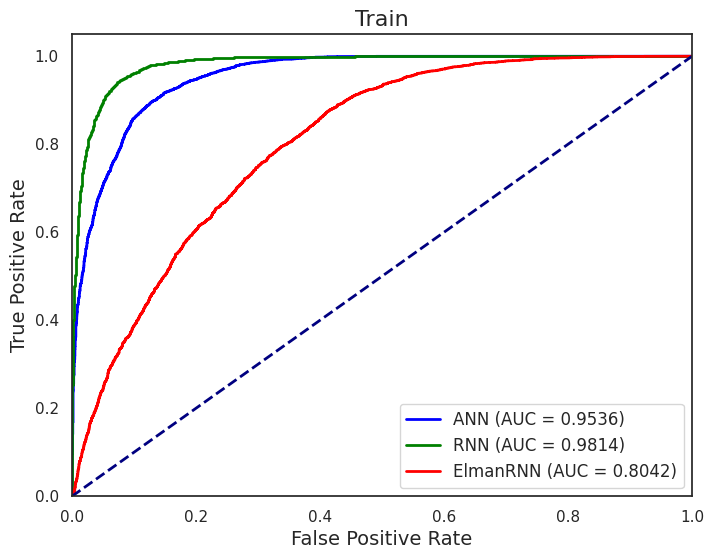

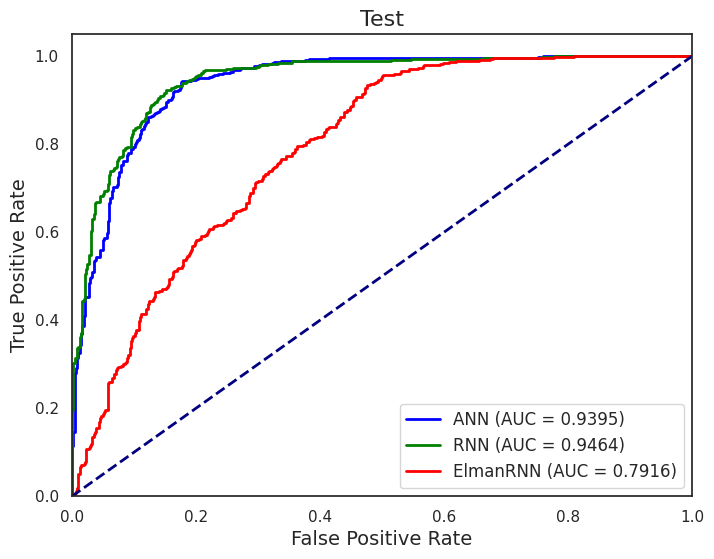

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    model = Sequential()
    if model_type == 'ANN':
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=1, activation='sigmoid'))

    return model

# Function to initialize GWO population
def initialize_gwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        wolf = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(wolf)
    return population

# Optimize model using GWO
def gwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'dropout': (0.1, 0.5)
    }
    population = initialize_gwo_population(5, param_bounds)  # Population size of 5 for GWO
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    # Initialize alpha, beta, and delta wolves
    alpha, beta, delta = None, None, None

    for generation in range(max_generations):
        a = 2 - generation * (2 / max_generations)  # Linearly decreased from 2 to 0

        # Evaluate all wolves
        for wolf in population:
            model = create_model(model_type, wolf, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            wolf['fitness'] = loss  # Lower loss is better

            if alpha is None or wolf['fitness'] < alpha['fitness']:
                delta = beta
                beta = alpha
                alpha = wolf
            elif beta is None or wolf['fitness'] < beta['fitness']:
                delta = beta
                beta = wolf
            elif delta is None or wolf['fitness'] < delta['fitness']:
                delta = wolf

        # Update positions of wolves
        for wolf in population:
            for key in wolf.keys():
                if key == 'fitness':
                    continue
                r1, r2 = np.random.rand(), np.random.rand()

                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[key] - wolf[key])
                X1 = alpha[key] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[key] - wolf[key])
                X2 = beta[key] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[key] - wolf[key])
                X3 = delta[key] - A3 * D_delta

                wolf[key] = (X1 + X2 + X3) / 3

                # Ensure the units are integers and valid
                if key.startswith('units'):
                    wolf[key] = max(8, int(round(wolf[key])))

                # Ensure dropouts remain within [0, 1] range
                if key.startswith('dropout'):
                    wolf[key] = min(max(wolf[key], 0), 1)

        # Track the best parameters found
        if alpha['fitness'] < best_fitness:
            best_fitness = alpha['fitness']
            best_params = alpha

        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types
model_types = ['ANN', 'RNN', 'ElmanRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = gwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('optimized_ann_rnn_elman_metrics.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


add encoder decoder BiRNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 1/3, Best Fitness: 0.3485986292362213


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 2/3, Best Fitness: 0.3485986292362213


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Generation 3/3, Best Fitness: 0.3485986292362213
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5418 - loss: 0.6982 - val_accuracy: 0.6771 - val_loss: 0.6596
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6027 - loss: 0.6643 - val_accuracy: 0.7418 - val_loss: 0.5632
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6676 - loss: 0.6082 - val_accuracy: 0.7654 - val_loss: 0.5256
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7072 - loss: 0.5839 - val_accuracy: 0.7769 - val_loss: 0.5007
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7204 - loss: 0.5565 - val_accuracy: 0.7884 - val_loss: 0.4840
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7325 - loss: 0.5405 - val_accuracy: 0.7926 - val_loss: 0.4702
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7492 - loss: 0.5211 - val_accuracy: 0.8059 - val_loss: 0.4587
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7461 - loss: 0.5117 - val_accuracy: 0.7975 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.3645764887332916


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.3645764887332916


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.3645764887332916


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5350 - loss: 0.7000 - val_accuracy: 0.6590 - val_loss: 0.6540
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6074 - loss: 0.6611 - val_accuracy: 0.6554 - val_loss: 0.6315
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6696 - loss: 0.6250 - val_accuracy: 0.6874 - val_loss: 0.5950
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6875 - loss: 0.5995 - val_accuracy: 0.7213 - val_loss: 0.5618
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6977 - loss: 0.5911 - val_accuracy: 0.7551 - val_loss: 0.5237
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7148 - loss: 0.5673 - val_accuracy: 0.6856 - val_loss: 0.5890
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7283 - loss: 0.5516 - val_accuracy: 0.7757 - val_loss: 0.4929
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7461 - loss: 0.5336 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 1/3, Best Fitness: 0.34787875413894653


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 2/3, Best Fitness: 0.33964985609054565


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a l

Generation 3/3, Best Fitness: 0.3173155188560486
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6107 - loss: 0.6518 - val_accuracy: 0.7866 - val_loss: 0.4746
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7517 - loss: 0.5320 - val_accuracy: 0.8198 - val_loss: 0.4274
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7911 - loss: 0.4751 - val_accuracy: 0.8210 - val_loss: 0.4274
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7985 - loss: 0.4539 - val_accuracy: 0.8132 - val_loss: 0.4227
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8183 - loss: 0.4251 - val_accuracy: 0.8331 - val_loss: 0.3834
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8275 - loss: 0.3999 - val_accuracy: 0.8307 - val_loss: 0.3866
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8122 - loss: 0.4288 - val_accuracy: 0.8434 - val_loss: 0.3979
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8268 - loss: 0.3971 - val_accuracy: 0.8440 -

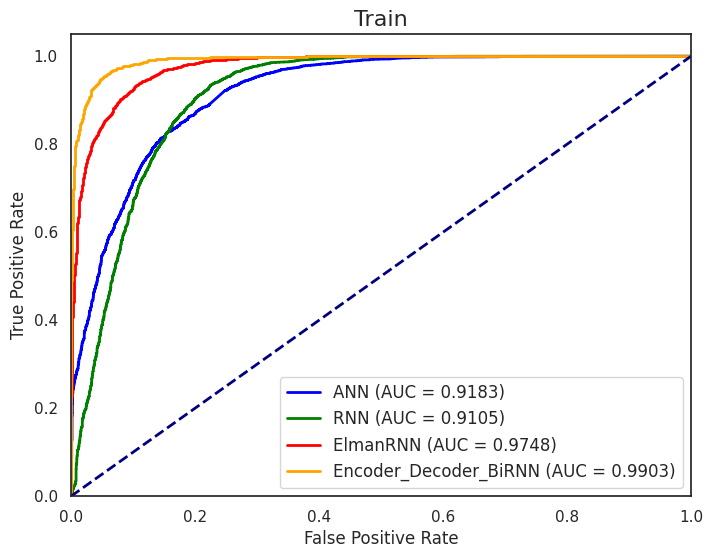

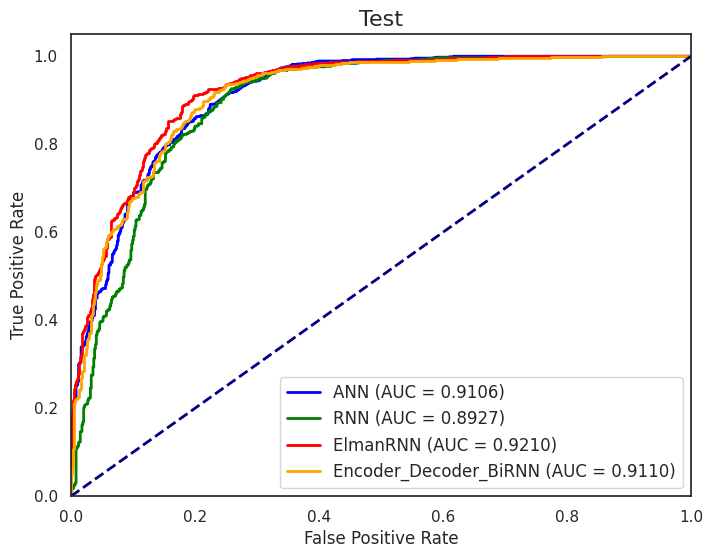

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Input, Bidirectional, LSTM, RepeatVector, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Function to create models
def create_model(model_type, params, input_feature_count):
    if model_type == 'ANN':
        model = Sequential()
        model.add(Dense(units=params['units1'], activation='relu', input_dim=input_feature_count))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'RNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=True))
        model.add(Dropout(params['dropout1']))
        model.add(SimpleRNN(units=params['units2'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout2']))
        model.add(SimpleRNN(units=params['units3'], activation='relu', return_sequences=True))
        model.add(Dropout(params['dropout3']))
        model.add(SimpleRNN(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'ElmanRNN':
        model = Sequential()
        model.add(SimpleRNN(units=params['units1'], activation='relu', input_shape=(input_feature_count, 1), return_sequences=False))
        model.add(Dropout(params['dropout1']))
        model.add(Dense(units=params['units2'], activation='relu'))
        model.add(Dropout(params['dropout2']))
        model.add(Dense(units=params['units3'], activation='relu'))
        model.add(Dropout(params['dropout3']))
        model.add(Dense(units=params['units4'], activation='relu'))
        model.add(Dropout(params['dropout4']))
        model.add(Dense(units=params['units5'], activation='relu'))
        model.add(Dropout(params['dropout5']))
        model.add(Dense(units=1, activation='sigmoid'))

    elif model_type == 'Encoder_Decoder_BiRNN':
        # Encoder
        encoder_inputs = Input(shape=(input_feature_count, 1))
        encoder = Bidirectional(LSTM(units=params['units1'], return_state=True, dropout=params['dropout1']))
        encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
        state_h = Concatenate()([forward_h, backward_h])
        state_c = Concatenate()([forward_c, backward_c])
        encoder_states = [state_h, state_c]

        # Decoder
        decoder_inputs = RepeatVector(1)(state_h)
        decoder_lstm = LSTM(units=params['units1'] * 2, return_sequences=False, dropout=params['dropout2'])
        decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(1, activation='sigmoid')
        outputs = decoder_dense(decoder_outputs)

        model = Model(inputs=encoder_inputs, outputs=outputs)

    return model

# Function to initialize GWO population
def initialize_gwo_population(pop_size, param_bounds):
    population = []
    for _ in range(pop_size):
        wolf = {
            'units1': np.random.randint(param_bounds['units1'][0], param_bounds['units1'][1] + 1),
            'units2': np.random.randint(param_bounds['units2'][0], param_bounds['units2'][1] + 1),
            'units3': np.random.randint(param_bounds['units3'][0], param_bounds['units3'][1] + 1),
            'units4': np.random.randint(param_bounds['units4'][0], param_bounds['units4'][1] + 1),
            'units5': np.random.randint(param_bounds['units5'][0], param_bounds['units5'][1] + 1),
            'dropout1': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout2': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout3': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout4': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'dropout5': np.random.uniform(param_bounds['dropout'][0], param_bounds['dropout'][1]),
            'fitness': None  # Initialize fitness
        }
        population.append(wolf)
    return population

# Optimize model using GWO
def gwo_optimize(model_type, X_train, y_train, X_val, y_val, input_feature_count):
    param_bounds = {
        'units1': (8, 128),
        'units2': (8, 64),
        'units3': (8, 32),
        'units4': (8, 16),
        'units5': (8, 8),
        'dropout': (0.1, 0.5)
    }
    population = initialize_gwo_population(5, param_bounds)  # Population size of 5 for GWO
    max_generations = 3

    best_fitness = float('inf')
    best_params = None

    # Initialize alpha, beta, and delta wolves
    alpha, beta, delta = None, None, None

    for generation in range(max_generations):
        a = 2 - generation * (2 / max_generations)  # Linearly decreased from 2 to 0

        # Evaluate all wolves
        for wolf in population:
            model = create_model(model_type, wolf, input_feature_count)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=20, verbose=0)  # Reduced verbosity for optimization
            loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
            wolf['fitness'] = loss  # Lower loss is better

            if alpha is None or wolf['fitness'] < alpha['fitness']:
                delta = beta
                beta = alpha
                alpha = wolf
            elif beta is None or wolf['fitness'] < beta['fitness']:
                delta = beta
                beta = wolf
            elif delta is None or wolf['fitness'] < delta['fitness']:
                delta = wolf

        # Update positions of wolves
        for wolf in population:
            for key in wolf.keys():
                if key == 'fitness':
                    continue
                r1, r2 = np.random.rand(), np.random.rand()

                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[key] - wolf[key])
                X1 = alpha[key] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[key] - wolf[key])
                X2 = beta[key] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[key] - wolf[key])
                X3 = delta[key] - A3 * D_delta

                wolf[key] = (X1 + X2 + X3) / 3

                # Ensure the units are integers and valid
                if key.startswith('units'):
                    wolf[key] = max(8, int(round(wolf[key])))

                # Ensure dropouts remain within [0, 1] range
                if key.startswith('dropout'):
                    wolf[key] = min(max(wolf[key], 0), 1)

        # Track the best parameters found
        if alpha['fitness'] < best_fitness:
            best_fitness = alpha['fitness']
            best_params = alpha

        print(f"Generation {generation+1}/{max_generations}, Best Fitness: {best_fitness}")

    return best_params

# Example model optimization and evaluation
input_feature_count = X_train_selected.shape[1]

# Define model types including the new Encoder-Decoder BiRNN
model_types = ['ANN', 'RNN', 'ElmanRNN', 'Encoder_Decoder_BiRNN']
color_dict = {'ANN': 'blue', 'RNN': 'green', 'ElmanRNN': 'red', 'Encoder_Decoder_BiRNN': 'orange'}

# Initialize dictionary to store FPR, TPR, and AUC for each model
roc_data_train = {}
roc_data_test = {}
metrics_data = {}

# Optimize and evaluate each model
for model_type in model_types:
    best_params = gwo_optimize(model_type, X_train_selected, y_train, X_val_selected, y_val, input_feature_count)
    model = create_model(model_type, best_params, input_feature_count)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    X_train_reshaped = np.expand_dims(X_train_selected, axis=-1) if 'RNN' in model_type else X_train_selected
    X_val_reshaped = np.expand_dims(X_val_selected, axis=-1) if 'RNN' in model_type else X_val_selected
    X_test_reshaped = np.expand_dims(X_test_selected, axis=-1) if 'RNN' in model_type else X_test_selected

    model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32, validation_data=(X_val_reshaped, y_val))

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict probabilities for the training set
    y_train_probs = model.predict(X_train_reshaped).ravel()

    # Predict probabilities for the test set
    y_test_probs = model.predict(X_test_reshaped).ravel()

    # Compute ROC curve and ROC area for the training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and ROC area for the test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    roc_data_train[model_type] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': roc_auc_train}
    roc_data_test[model_type] = {'fpr': fpr_test, 'tpr': tpr_test, 'auc': roc_auc_test}

    # Calculate metrics
    y_test_pred = (y_test_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)  # Sensitivity
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_test_pred)

    metrics_data[model_type] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': recall,
        'Specificity': specificity,
        'F1 Score': f1
    }

# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_data).transpose()

# Display the DataFrame
print(metrics_df)

# Optionally, save the DataFrame to a CSV file
metrics_df.to_csv('gwo_optimised_ann_rnn_elman_metrics.csv', index=True)

# Plot ROC curves for training data
plt.figure(figsize=(8, 6))
for model_type in roc_data_train.keys():
    plt.plot(roc_data_train[model_type]['fpr'], roc_data_train[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_train[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

# Plot ROC curves for testing data
plt.figure(figsize=(8, 6))
for model_type in roc_data_test.keys():
    plt.plot(roc_data_test[model_type]['fpr'], roc_data_test[model_type]['tpr'],
             color=color_dict[model_type], lw=2,
             label=f'{model_type} (AUC = {roc_data_test[model_type]["auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()
